In [1]:
import os
import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from tqdm import tqdm 
from sklearn.metrics import accuracy_score, classification_report

import torch
import torch.nn.functional as F
from torch.utils import data
from torchinfo import summary
import torch.nn as nn
import torch.optim as optim

# 读取数据

In [2]:
file_dir = "./FBDQA2021A_MMP_Challenge_ver0.2/data"

sym = 4
dates = list(range(24))
df = pd.DataFrame()
for date in dates:
    if (date & 1):
        file_name = f"snapshot_sym{sym}_date{date//2}_am.csv"
    else:
        file_name = f"snapshot_sym{sym}_date{date//2}_pm.csv"
    if not os.path.isfile(os.path.join(file_dir,file_name)):
        continue
    new_df = pd.read_csv(os.path.join(file_dir,file_name))
    # 价格+1（从涨跌幅还原到对前收盘价的比例）
    new_df['bid1'] = new_df['n_bid1']+1
    new_df['bid2'] = new_df['n_bid2']+1
    new_df['bid3'] = new_df['n_bid3']+1
    new_df['bid4'] = new_df['n_bid4']+1
    new_df['bid5'] = new_df['n_bid5']+1
    new_df['ask1'] = new_df['n_ask1']+1
    new_df['ask2'] = new_df['n_ask2']+1
    new_df['ask3'] = new_df['n_ask3']+1
    new_df['ask4'] = new_df['n_ask4']+1
    new_df['ask5'] = new_df['n_ask5']+1
    
    # 量价组合
    new_df['spread1'] =  new_df['ask1'] - new_df['bid1']
    new_df['spread2'] =  new_df['ask2'] - new_df['bid2']
    new_df['spread3'] =  new_df['ask3'] - new_df['bid3']
    new_df['mid_price1'] =  new_df['ask1'] + new_df['bid1']
    new_df['mid_price2'] =  new_df['ask2'] + new_df['bid2']
    new_df['mid_price3'] =  new_df['ask3'] + new_df['bid3']
    new_df['weighted_ab1'] = (new_df['ask1'] * new_df['n_bsize1'] + new_df['bid1'] * new_df['n_asize1']) / (new_df['n_bsize1'] + new_df['n_asize1'])
    new_df['weighted_ab2'] = (new_df['ask2'] * new_df['n_bsize2'] + new_df['bid2'] * new_df['n_asize2']) / (new_df['n_bsize2'] + new_df['n_asize2'])
    new_df['weighted_ab3'] = (new_df['ask3'] * new_df['n_bsize3'] + new_df['bid3'] * new_df['n_asize3']) / (new_df['n_bsize3'] + new_df['n_asize3'])
    
    new_df['vol1_rel_diff']   = (new_df['n_bsize1'] - new_df['n_asize1']) / (new_df['n_bsize1'] + new_df['n_asize1'])
    new_df['volall_rel_diff'] = (new_df['n_bsize1'] + new_df['n_bsize2'] + new_df['n_bsize3'] + new_df['n_bsize4'] + new_df['n_bsize5'] \
                     - new_df['n_asize1'] - new_df['n_asize2'] - new_df['n_asize3'] - new_df['n_asize4'] - new_df['n_asize5'] ) / \
                     ( new_df['n_bsize1'] + new_df['n_bsize2'] + new_df['n_bsize3'] + new_df['n_bsize4'] + new_df['n_bsize5'] \
                     + new_df['n_asize1'] + new_df['n_asize2'] + new_df['n_asize3'] + new_df['n_asize4'] + new_df['n_asize5'] )
                            
    new_df['amount'] = new_df['amount_delta'].map(np.log1p)
    df = df.append(new_df)
    




In [3]:
df

,date,time,sym,n_close,amount_delta,n_midprice,n_bid1,n_bsize1,n_bid2,n_bsize2,...,spread3,mid_price1,mid_price2,mid_price3,weighted_ab1,weighted_ab2,weighted_ab3,vol1_rel_diff,volall_rel_diff,amount
0,0,13:10:03,4,-0.014876,25032.0,-0.015289,-0.015702,2.584610e-05,-0.016529,0.000081,...,0.004132,1.969421,1.969421,1.969421,0.984760,0.985554,0.986383,0.118386,0.626549,10.127950
1,0,13:10:06,4,-0.014876,0.0,-0.015289,-0.015702,2.584610e-05,-0.016529,0.000081,...,0.004132,1.969421,1.969421,1.969421,0.984808,0.985554,0.986383,0.235822,0.650704,0.000000
2,0,13:10:09,4,-0.015702,1669544.0,-0.016116,-0.016529,8.080050e-05,-0.017355,0.000031,...,0.004132,1.967769,1.967769,1.967769,0.984194,0.984272,0.985212,0.749770,0.675229,14.328062
3,0,13:10:12,4,-0.016529,21420.0,-0.016116,-0.016529,8.054896e-05,-0.017355,0.000031,...,0.004132,1.967769,1.967769,1.967769,0.984194,0.984272,0.985212,0.749086,0.669201,9.972127
4,0,13:10:15,4,-0.016529,0.0,-0.016116,-0.016529,8.056831e-05,-0.017355,0.000031,...,0.004132,1.967769,1.967769,1.967769,0.984194,0.984272,0.985217,0.749139,0.669819,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1994,11,11:19:45,4,-0.004680,1665200.0,-0.003900,-0.004680,1.613688e-05,-0.005460,0.000010,...,0.004680,1.992200,1.992200,1.992200,0.996736,0.995265,0.994582,0.815016,-0.332393,14.325456
1995,11,11:19:48,4,-0.004680,66353.0,-0.003900,-0.004680,1.524684e-05,-0.005460,0.000010,...,0.004680,1.992200,1.992200,1.992200,0.996692,0.995263,0.994582,0.758929,-0.340953,11.102759
1996,11,11:19:51,4,-0.004680,0.0,-0.003900,-0.004680,1.495661e-05,-0.005460,0.000011,...,0.004680,1.992200,1.992200,1.992200,0.996754,0.995279,0.994582,0.838288,-0.338120,0.000000
1997,11,11:19:54,4,-0.003120,28114.0,-0.003510,-0.003900,6.385097e-07,-0.004680,0.000001,...,0.003900,1.992980,1.992980,1.992980,0.996153,0.995398,0.995311,-0.862786,-0.574108,10.244059


In [4]:
feature_col_names = ['bid1','n_bsize1',
                     'bid2','n_bsize2',
                     'bid3','n_bsize3',
                     'bid4','n_bsize4',
                     'bid5','n_bsize5',
                     'ask1','n_asize1',
                     'ask2','n_asize2',
                     'ask3','n_asize3',
                     'ask4','n_asize4',
                     'ask5','n_asize5',
                     'spread1','mid_price1',
                     'spread2','mid_price2',
                     'spread3','mid_price3',
                     'weighted_ab1','weighted_ab2','weighted_ab3','amount',
                     'vol1_rel_diff','volall_rel_diff'
                    ]
label_col_name = ['label_5']

In [5]:
n = len(df)
##划分训练/测试集
train_nums = int(n*0.8)
val_nums = int(n*0.1)
print(f'train_nums: {train_nums}, val_nums: {val_nums}, test_nums: {n-train_nums-val_nums}')
train_data = np.ascontiguousarray(df[feature_col_names][:train_nums].values)
train_label = df[label_col_name][:train_nums].values.reshape(-1)

val_data = np.ascontiguousarray(df[feature_col_names][train_nums:train_nums+val_nums].values)
val_label = df[label_col_name][train_nums:train_nums+val_nums].values.reshape(-1)

test_data = np.ascontiguousarray(df[feature_col_names][train_nums+val_nums:].values)
test_label = df[label_col_name][train_nums+val_nums:].values.reshape(-1)

train_nums: 38380, val_nums: 4797, test_nums: 4799


## GPU准备

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## 准备dataset

In [7]:
def data_transform(X, T):
    [N, D] = X.shape
    dataX = np.zeros((N - T + 1, T, D))
    for i in range(T, N + 1):
        dataX[i - T] = X[i - T:i, :]
    return dataX

In [8]:
class Dataset(data.Dataset):
    def __init__(self, data, label,  num_classes, T):
        self.T = T

        data = data_transform(data, self.T)

        self.x = torch.tensor(data).to(torch.float32).unsqueeze(1).to(device)

        self.y = torch.tensor(label[T - 1:].astype(np.int64)).to(device)
    
        self.length = len(self.x)

    def __len__(self):
        return self.length

    def __getitem__(self, index):
        return self.x[index], self.y[index]

In [9]:
batch_size = 512

dataset_train = Dataset(data=train_data,label=train_label, num_classes=3, T=100)
dataset_val   = Dataset(data=val_data,  label=val_label,   num_classes=3, T=100)
dataset_test  = Dataset(data=test_data, label=test_label,  num_classes=3, T=100)

train_loader = torch.utils.data.DataLoader(dataset=dataset_train, batch_size=batch_size, shuffle=True)
val_loader   = torch.utils.data.DataLoader(dataset=dataset_val, batch_size=batch_size, shuffle=False)
test_loader  = torch.utils.data.DataLoader(dataset=dataset_test, batch_size=batch_size, shuffle=False)

torch.Size([38281, 1, 100, 32]) torch.Size([38281]) False False
torch.Size([4698, 1, 100, 32]) torch.Size([4698]) False False
torch.Size([4700, 1, 100, 32]) torch.Size([4700]) False False


In [10]:
print(dataset_train.x.device)
print(dataset_train.y.device)

cuda:0
cuda:0


# 定义模型

In [11]:
class deeplob(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.num_classes = num_classes
        
        # convolution blocks
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(1,2), stride=(1,2)),
            nn.LeakyReLU(negative_slope=0.01),
#             nn.Tanh(),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(4,1)),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(5,1),stride=(2,1)),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(32),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(1,2), stride=(1,2)),
            nn.Tanh(),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(4,1)),
            nn.Tanh(),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(4,1),stride=(2,1)),
            nn.Tanh(),
            nn.BatchNorm2d(32),
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(1,8)),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(4,1)),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(4,1),stride=(2,1)),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(32),
        )
        
        # inception moduels
        self.inp1 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(1,1), padding='same'),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(64),
            nn.Conv2d(in_channels=64, out_channels=16, kernel_size=(3,1), padding='same'),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(16),
        )
        self.inp2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(1,1), padding='same'),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(64),
            nn.Conv2d(in_channels=64, out_channels=16, kernel_size=(5,1), padding='same'),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(16),
        )
        self.inp3 = nn.Sequential(
            nn.MaxPool2d((3, 1), stride=(1, 1), padding=(1, 0)),
            nn.Conv2d(in_channels=32, out_channels=16, kernel_size=(1,1), padding='same'),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(16),
        )
       
        # lstm layers
        self.fc = nn.Sequential(nn.Linear(384, 64),nn.Linear(64, self.num_classes))

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)

        x_inp1 = self.inp1(x)
        x_inp2 = self.inp2(x)
        x_inp3 = self.inp3(x)

        x = torch.cat((x_inp1, x_inp2, x_inp3), dim=1)

        x = x.reshape(-1,48*8)
        x = self.fc(x)

        forecast_y = torch.softmax(x, dim=1)

        return forecast_y

In [12]:
model = deeplob(num_classes = 3)
model.to(device);

In [13]:
summary(model, (1, 1, 100, 32))

Layer (type:depth-idx)                   Output Shape              Param #
deeplob                                  --                        --
├─Sequential: 1-1                        [1, 32, 47, 16]           --
│    └─Conv2d: 2-1                       [1, 32, 100, 16]          96
│    └─LeakyReLU: 2-2                    [1, 32, 100, 16]          --
│    └─BatchNorm2d: 2-3                  [1, 32, 100, 16]          64
│    └─Conv2d: 2-4                       [1, 32, 97, 16]           4,128
│    └─LeakyReLU: 2-5                    [1, 32, 97, 16]           --
│    └─BatchNorm2d: 2-6                  [1, 32, 97, 16]           64
│    └─Conv2d: 2-7                       [1, 32, 47, 16]           5,152
│    └─LeakyReLU: 2-8                    [1, 32, 47, 16]           --
│    └─BatchNorm2d: 2-9                  [1, 32, 47, 16]           64
├─Sequential: 1-2                        [1, 32, 21, 8]            --
│    └─Conv2d: 2-10                      [1, 32, 47, 8]            2,080
│    └

# 训练模型

In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay = 1e-5)

In [15]:
def batch_gd(model, criterion, optimizer, train_loader, test_loader, epochs):
    
    train_losses = np.zeros(epochs)
    test_losses = np.zeros(epochs)
    best_test_loss = np.inf
    best_test_epoch = 0

    for it in tqdm(range(epochs)):
        if ((epochs+1) % 10 == 0):
            optimizer.lr = optimizer.lr*0.5
        model.train()
        t0 = datetime.now()
        train_loss = []
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            
            outputs = model(inputs)

            loss = criterion(outputs, targets)

            loss.backward()
            
            optimizer.step()
            
            train_loss.append(loss.item())
            
        # Get train loss and test loss
        train_loss = np.mean(train_loss) # a little misleading
    
        model.eval()
        test_loss = []
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device, dtype=torch.float), targets.to(device, dtype=torch.int64)      
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss.append(loss.item())
        test_loss = np.mean(test_loss)

        # Save losses
        train_losses[it] = train_loss
        test_losses[it] = test_loss
        
        if test_loss < best_test_loss:
            torch.save(model, f'best_val_model_pytorch_sym{sym}_date{dates[-1]}')
            best_test_loss = test_loss
            best_test_epoch = it
            print('model saved')

        dt = datetime.now() - t0
        print(f'Epoch {it+1}/{epochs}, Train Loss: {train_loss:.4f}, \
          Validation Loss: {test_loss:.4f}, Duration: {dt}, Best Val Epoch: {best_test_epoch}')
    torch.save(model, f'final_model_pytorch_sym{sym}_date{dates[-1]}')
    return train_losses, test_losses

In [16]:
train_losses, val_losses = batch_gd(model, criterion, optimizer, 
                                    train_loader, val_loader, epochs=50)

  2%|▏         | 1/50 [00:02<01:39,  2.03s/it]

model saved
Epoch 1/50, Train Loss: 1.0817,           Validation Loss: 1.1908, Duration: 0:00:02.032294, Best Val Epoch: 0


  4%|▍         | 2/50 [00:04<01:37,  2.04s/it]

model saved
Epoch 2/50, Train Loss: 1.0430,           Validation Loss: 1.0123, Duration: 0:00:02.039354, Best Val Epoch: 1


  6%|▌         | 3/50 [00:05<01:32,  1.98s/it]

model saved
Epoch 3/50, Train Loss: 1.0021,           Validation Loss: 0.9693, Duration: 0:00:01.899860, Best Val Epoch: 2


  8%|▊         | 4/50 [00:08<01:33,  2.04s/it]

model saved
Epoch 4/50, Train Loss: 0.9755,           Validation Loss: 0.9628, Duration: 0:00:02.133483, Best Val Epoch: 3


 10%|█         | 5/50 [00:10<01:29,  1.99s/it]

Epoch 5/50, Train Loss: 0.9582,           Validation Loss: 0.9683, Duration: 0:00:01.896302, Best Val Epoch: 3


 12%|█▏        | 6/50 [00:12<01:27,  2.00s/it]

model saved
Epoch 6/50, Train Loss: 0.9477,           Validation Loss: 0.9452, Duration: 0:00:02.018665, Best Val Epoch: 5


 14%|█▍        | 7/50 [00:14<01:25,  2.00s/it]

Epoch 7/50, Train Loss: 0.9414,           Validation Loss: 0.9467, Duration: 0:00:01.993609, Best Val Epoch: 5


 16%|█▌        | 8/50 [00:15<01:23,  1.98s/it]

model saved
Epoch 8/50, Train Loss: 0.9369,           Validation Loss: 0.9369, Duration: 0:00:01.953085, Best Val Epoch: 7


 18%|█▊        | 9/50 [00:18<01:22,  2.01s/it]

model saved
Epoch 9/50, Train Loss: 0.9341,           Validation Loss: 0.9306, Duration: 0:00:02.066743, Best Val Epoch: 8


 20%|██        | 10/50 [00:19<01:19,  1.99s/it]

Epoch 10/50, Train Loss: 0.9316,           Validation Loss: 0.9424, Duration: 0:00:01.954969, Best Val Epoch: 8


 22%|██▏       | 11/50 [00:22<01:18,  2.00s/it]

model saved
Epoch 11/50, Train Loss: 0.9300,           Validation Loss: 0.9186, Duration: 0:00:02.027464, Best Val Epoch: 10


 24%|██▍       | 12/50 [00:23<01:15,  1.99s/it]

Epoch 12/50, Train Loss: 0.9285,           Validation Loss: 0.9226, Duration: 0:00:01.957130, Best Val Epoch: 10


 26%|██▌       | 13/50 [00:25<01:13,  1.98s/it]

model saved
Epoch 13/50, Train Loss: 0.9271,           Validation Loss: 0.9143, Duration: 0:00:01.960413, Best Val Epoch: 12


 28%|██▊       | 14/50 [00:27<01:11,  1.99s/it]

Epoch 14/50, Train Loss: 0.9258,           Validation Loss: 0.9182, Duration: 0:00:02.005088, Best Val Epoch: 12


 30%|███       | 15/50 [00:29<01:08,  1.97s/it]

Epoch 15/50, Train Loss: 0.9246,           Validation Loss: 0.9209, Duration: 0:00:01.915996, Best Val Epoch: 12


 32%|███▏      | 16/50 [00:31<01:07,  1.97s/it]

Epoch 16/50, Train Loss: 0.9236,           Validation Loss: 0.9166, Duration: 0:00:01.978704, Best Val Epoch: 12


 34%|███▍      | 17/50 [00:33<01:04,  1.95s/it]

Epoch 17/50, Train Loss: 0.9224,           Validation Loss: 0.9180, Duration: 0:00:01.898961, Best Val Epoch: 12


 36%|███▌      | 18/50 [00:35<01:01,  1.93s/it]

Epoch 18/50, Train Loss: 0.9213,           Validation Loss: 0.9169, Duration: 0:00:01.884275, Best Val Epoch: 12


 38%|███▊      | 19/50 [00:37<01:00,  1.96s/it]

Epoch 19/50, Train Loss: 0.9205,           Validation Loss: 0.9246, Duration: 0:00:02.020889, Best Val Epoch: 12


 40%|████      | 20/50 [00:39<00:58,  1.95s/it]

Epoch 20/50, Train Loss: 0.9196,           Validation Loss: 0.9235, Duration: 0:00:01.939717, Best Val Epoch: 12


 42%|████▏     | 21/50 [00:41<00:57,  2.00s/it]

Epoch 21/50, Train Loss: 0.9187,           Validation Loss: 0.9297, Duration: 0:00:02.100909, Best Val Epoch: 12


 44%|████▍     | 22/50 [00:43<00:54,  1.96s/it]

Epoch 22/50, Train Loss: 0.9188,           Validation Loss: 0.9210, Duration: 0:00:01.883162, Best Val Epoch: 12


 46%|████▌     | 23/50 [00:45<00:53,  2.00s/it]

Epoch 23/50, Train Loss: 0.9183,           Validation Loss: 0.9416, Duration: 0:00:02.083645, Best Val Epoch: 12


 48%|████▊     | 24/50 [00:47<00:51,  1.99s/it]

Epoch 24/50, Train Loss: 0.9166,           Validation Loss: 0.9478, Duration: 0:00:01.978045, Best Val Epoch: 12


 50%|█████     | 25/50 [00:49<00:49,  1.99s/it]

Epoch 25/50, Train Loss: 0.9155,           Validation Loss: 0.9383, Duration: 0:00:01.972750, Best Val Epoch: 12


 52%|█████▏    | 26/50 [00:51<00:48,  2.00s/it]

Epoch 26/50, Train Loss: 0.9152,           Validation Loss: 0.9149, Duration: 0:00:02.028212, Best Val Epoch: 12


 54%|█████▍    | 27/50 [00:53<00:45,  1.98s/it]

Epoch 27/50, Train Loss: 0.9137,           Validation Loss: 0.9204, Duration: 0:00:01.947204, Best Val Epoch: 12


 56%|█████▌    | 28/50 [00:55<00:44,  2.00s/it]

Epoch 28/50, Train Loss: 0.9131,           Validation Loss: 0.9242, Duration: 0:00:02.048584, Best Val Epoch: 12


 58%|█████▊    | 29/50 [00:57<00:41,  2.00s/it]

Epoch 29/50, Train Loss: 0.9121,           Validation Loss: 0.9456, Duration: 0:00:01.988019, Best Val Epoch: 12


 60%|██████    | 30/50 [00:59<00:40,  2.02s/it]

Epoch 30/50, Train Loss: 0.9114,           Validation Loss: 0.9208, Duration: 0:00:02.072769, Best Val Epoch: 12


 62%|██████▏   | 31/50 [01:01<00:38,  2.01s/it]

Epoch 31/50, Train Loss: 0.9100,           Validation Loss: 0.9148, Duration: 0:00:01.981780, Best Val Epoch: 12


 64%|██████▍   | 32/50 [01:03<00:35,  2.00s/it]

Epoch 32/50, Train Loss: 0.9095,           Validation Loss: 0.9165, Duration: 0:00:01.966397, Best Val Epoch: 12


 66%|██████▌   | 33/50 [01:05<00:34,  2.01s/it]

Epoch 33/50, Train Loss: 0.9088,           Validation Loss: 0.9329, Duration: 0:00:02.029444, Best Val Epoch: 12


 68%|██████▊   | 34/50 [01:07<00:32,  2.00s/it]

Epoch 34/50, Train Loss: 0.9080,           Validation Loss: 0.9302, Duration: 0:00:01.985203, Best Val Epoch: 12


 70%|███████   | 35/50 [01:09<00:30,  2.04s/it]

Epoch 35/50, Train Loss: 0.9069,           Validation Loss: 0.9220, Duration: 0:00:02.138830, Best Val Epoch: 12


 72%|███████▏  | 36/50 [01:11<00:28,  2.04s/it]

Epoch 36/50, Train Loss: 0.9061,           Validation Loss: 0.9311, Duration: 0:00:02.046022, Best Val Epoch: 12


 74%|███████▍  | 37/50 [01:14<00:26,  2.07s/it]

Epoch 37/50, Train Loss: 0.9051,           Validation Loss: 0.9549, Duration: 0:00:02.127995, Best Val Epoch: 12


 76%|███████▌  | 38/50 [01:16<00:24,  2.06s/it]

Epoch 38/50, Train Loss: 0.9047,           Validation Loss: 0.9228, Duration: 0:00:02.046101, Best Val Epoch: 12


 78%|███████▊  | 39/50 [01:18<00:22,  2.06s/it]

Epoch 39/50, Train Loss: 0.9032,           Validation Loss: 0.9406, Duration: 0:00:02.051963, Best Val Epoch: 12


 80%|████████  | 40/50 [01:20<00:20,  2.06s/it]

Epoch 40/50, Train Loss: 0.9015,           Validation Loss: 0.9227, Duration: 0:00:02.047410, Best Val Epoch: 12


 82%|████████▏ | 41/50 [01:22<00:18,  2.01s/it]

Epoch 41/50, Train Loss: 0.9014,           Validation Loss: 0.9250, Duration: 0:00:01.885903, Best Val Epoch: 12


 84%|████████▍ | 42/50 [01:23<00:15,  1.99s/it]

Epoch 42/50, Train Loss: 0.8999,           Validation Loss: 0.9444, Duration: 0:00:01.960986, Best Val Epoch: 12


 86%|████████▌ | 43/50 [01:25<00:13,  1.97s/it]

Epoch 43/50, Train Loss: 0.9000,           Validation Loss: 0.9279, Duration: 0:00:01.903363, Best Val Epoch: 12


 88%|████████▊ | 44/50 [01:27<00:11,  1.98s/it]

Epoch 44/50, Train Loss: 0.8991,           Validation Loss: 0.9327, Duration: 0:00:02.016947, Best Val Epoch: 12


 90%|█████████ | 45/50 [01:29<00:09,  1.99s/it]

Epoch 45/50, Train Loss: 0.8973,           Validation Loss: 0.9247, Duration: 0:00:01.991327, Best Val Epoch: 12


 92%|█████████▏| 46/50 [01:31<00:07,  1.99s/it]

Epoch 46/50, Train Loss: 0.8968,           Validation Loss: 0.9362, Duration: 0:00:01.994886, Best Val Epoch: 12


 94%|█████████▍| 47/50 [01:33<00:06,  2.02s/it]

Epoch 47/50, Train Loss: 0.8952,           Validation Loss: 0.9177, Duration: 0:00:02.088059, Best Val Epoch: 12


 96%|█████████▌| 48/50 [01:35<00:04,  2.01s/it]

Epoch 48/50, Train Loss: 0.8949,           Validation Loss: 0.9234, Duration: 0:00:01.986558, Best Val Epoch: 12


 98%|█████████▊| 49/50 [01:38<00:02,  2.02s/it]

Epoch 49/50, Train Loss: 0.8945,           Validation Loss: 0.9541, Duration: 0:00:02.045556, Best Val Epoch: 12


100%|██████████| 50/50 [01:40<00:00,  2.00s/it]

Epoch 50/50, Train Loss: 0.8935,           Validation Loss: 0.9592, Duration: 0:00:01.984888, Best Val Epoch: 12


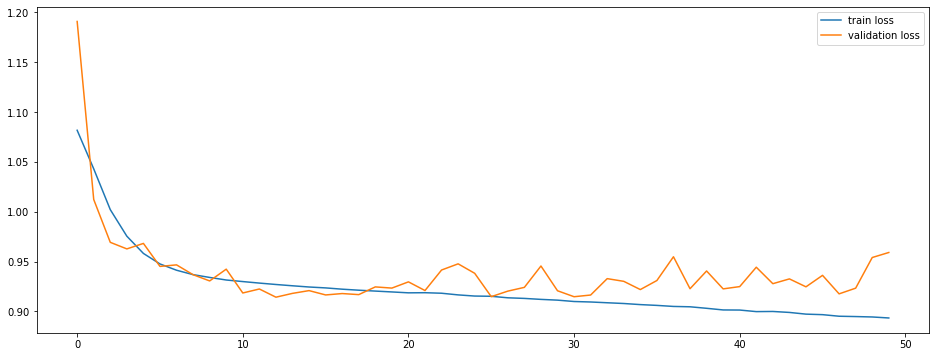

In [17]:
plt.figure(figsize=(16,6))
plt.plot(train_losses, label='train loss')
plt.plot(val_losses, label='validation loss')
plt.legend()

# 测试模型

In [18]:
model = torch.load(f'best_val_model_pytorch_sym{sym}_date{dates[-1]}', map_location=device)
model.eval()
all_targets = []
all_predictions = []

for inputs, targets in test_loader:
    # Move to GPU
    inputs, targets = inputs.to(device, dtype=torch.float), targets.to(device, dtype=torch.int64)

    # Forward pass
    outputs = model(inputs)
    
    # Get prediction
    # torch.max returns both max and argmax
    _, predictions = torch.max(outputs, 1)

    all_targets.append(targets.cpu().numpy())
    all_predictions.append(predictions.cpu().numpy())

all_targets = np.concatenate(all_targets)    
all_predictions = np.concatenate(all_predictions)    
print('accuracy_score:', accuracy_score(all_targets, all_predictions))
print(classification_report(all_targets, all_predictions, digits=4))

accuracy_score: 0.7074468085106383
              precision    recall  f1-score   support

           0     1.0000    0.0027    0.0054       742
           1     0.7074    1.0000    0.8287      3320
           2     0.6000    0.0047    0.0093       638

    accuracy                         0.7074      4700
   macro avg     0.7691    0.3358    0.2811      4700
weighted avg     0.7390    0.7074    0.5875      4700



In [19]:
# model = torch.load('best_val_model_pytorch',map_location=device)
all_targets = []
all_predictions = []

for inputs, targets in train_loader:

    # Forward pass
    outputs = model(inputs)
    
    # Get prediction
    # torch.max returns both max and argmax
    _, predictions = torch.max(outputs, 1)

    all_targets.append(targets.cpu().numpy())
    all_predictions.append(predictions.cpu().numpy())

all_targets = np.concatenate(all_targets)    
all_predictions = np.concatenate(all_predictions) 
print('accuracy_score:', accuracy_score(all_targets, all_predictions))
print(classification_report(all_targets, all_predictions, digits=4))

accuracy_score: 0.615213813641232
              precision    recall  f1-score   support

           0     0.3305    0.0592    0.1004      7350
           1     0.6394    0.9432    0.7621     23831
           2     0.3528    0.0900    0.1434      7100

    accuracy                         0.6152     38281
   macro avg     0.4409    0.3641    0.3353     38281
weighted avg     0.5269    0.6152    0.5203     38281



# 过拟合：小规模数据难以充分训练大模型

In [26]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP,self).__init__()
        self.net = nn.Sequential(
                    nn.Linear(3200,128),
                    nn.LeakyReLU(),
                    nn.Linear(128,64),
                    nn.LeakyReLU(),
                    nn.Linear(64,64),
                    nn.LeakyReLU(),
                    nn.Linear(64,3)
                )
        
    def forward(self,x):
        x = x.view(-1,100*32)
        x = self.net(x)
        return torch.softmax(x, dim=1)

In [27]:
model = MLP()
model.to(device)
summary(model,(1,1,100,32))

Layer (type:depth-idx)                   Output Shape              Param #
MLP                                      --                        --
├─Sequential: 1-1                        [1, 3]                    --
│    └─Linear: 2-1                       [1, 128]                  409,728
│    └─LeakyReLU: 2-2                    [1, 128]                  --
│    └─Linear: 2-3                       [1, 64]                   8,256
│    └─LeakyReLU: 2-4                    [1, 64]                   --
│    └─Linear: 2-5                       [1, 64]                   4,160
│    └─LeakyReLU: 2-6                    [1, 64]                   --
│    └─Linear: 2-7                       [1, 3]                    195
Total params: 422,339
Trainable params: 422,339
Non-trainable params: 0
Total mult-adds (M): 0.42
Input size (MB): 0.01
Forward/backward pass size (MB): 0.00
Params size (MB): 1.69
Estimated Total Size (MB): 1.70

In [28]:
criterion = nn.CrossEntropyLoss(weight = torch.Tensor([2,1,2]).to(device))
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)#, momentum=0.9, weight_decay = 1e-5)

In [29]:
train_losses, val_losses = batch_gd2(model, criterion, optimizer, 
                                    train_loader, val_loader, epochs=500)

  0%|          | 1/500 [00:00<03:22,  2.47it/s]

model saved
Epoch 1/500, Train Loss: 1.0597,           Validation Loss: 1.0666, Duration: 0:00:00.405264, Best Val Epoch: 0


  0%|          | 2/500 [00:00<03:36,  2.30it/s]

model saved
Epoch 2/500, Train Loss: 1.0478,           Validation Loss: 1.0490, Duration: 0:00:00.454608, Best Val Epoch: 1


  1%|          | 3/500 [00:01<03:26,  2.40it/s]

model saved
Epoch 3/500, Train Loss: 1.0479,           Validation Loss: 1.0337, Duration: 0:00:00.394073, Best Val Epoch: 2


  1%|          | 4/500 [00:01<03:21,  2.46it/s]

Epoch 4/500, Train Loss: 1.0426,           Validation Loss: 1.0347, Duration: 0:00:00.391832, Best Val Epoch: 2


  1%|          | 5/500 [00:02<03:27,  2.38it/s]

Epoch 5/500, Train Loss: 1.0364,           Validation Loss: 1.0698, Duration: 0:00:00.443071, Best Val Epoch: 2


  1%|          | 6/500 [00:02<03:23,  2.43it/s]

model saved
Epoch 6/500, Train Loss: 1.0344,           Validation Loss: 1.0150, Duration: 0:00:00.395173, Best Val Epoch: 5


  1%|▏         | 7/500 [00:02<03:36,  2.28it/s]

model saved
Epoch 7/500, Train Loss: 1.0205,           Validation Loss: 1.0040, Duration: 0:00:00.494161, Best Val Epoch: 6


  2%|▏         | 8/500 [00:03<03:36,  2.27it/s]

Epoch 8/500, Train Loss: 1.0107,           Validation Loss: 1.0062, Duration: 0:00:00.444206, Best Val Epoch: 6


  2%|▏         | 9/500 [00:03<03:37,  2.26it/s]

model saved
Epoch 9/500, Train Loss: 1.0034,           Validation Loss: 0.9993, Duration: 0:00:00.446367, Best Val Epoch: 8


  2%|▏         | 10/500 [00:04<03:44,  2.19it/s]

model saved
Epoch 10/500, Train Loss: 0.9937,           Validation Loss: 0.9918, Duration: 0:00:00.489918, Best Val Epoch: 9


  2%|▏         | 11/500 [00:04<03:41,  2.20it/s]

Epoch 11/500, Train Loss: 0.9945,           Validation Loss: 0.9936, Duration: 0:00:00.443602, Best Val Epoch: 9


  2%|▏         | 12/500 [00:05<03:43,  2.19it/s]

Epoch 12/500, Train Loss: 0.9880,           Validation Loss: 1.0060, Duration: 0:00:00.465983, Best Val Epoch: 9


  3%|▎         | 13/500 [00:05<03:41,  2.20it/s]

model saved
Epoch 13/500, Train Loss: 0.9950,           Validation Loss: 0.9754, Duration: 0:00:00.448366, Best Val Epoch: 12


  3%|▎         | 14/500 [00:06<03:39,  2.21it/s]

Epoch 14/500, Train Loss: 0.9856,           Validation Loss: 0.9846, Duration: 0:00:00.445122, Best Val Epoch: 12


  3%|▎         | 15/500 [00:06<03:38,  2.22it/s]

Epoch 15/500, Train Loss: 0.9786,           Validation Loss: 0.9782, Duration: 0:00:00.448506, Best Val Epoch: 12


  3%|▎         | 16/500 [00:07<03:29,  2.31it/s]

Epoch 16/500, Train Loss: 0.9810,           Validation Loss: 1.0063, Duration: 0:00:00.391374, Best Val Epoch: 12


  3%|▎         | 17/500 [00:07<03:32,  2.27it/s]

model saved
Epoch 17/500, Train Loss: 0.9832,           Validation Loss: 0.9752, Duration: 0:00:00.453608, Best Val Epoch: 16


  4%|▎         | 18/500 [00:07<03:25,  2.34it/s]

Epoch 18/500, Train Loss: 0.9815,           Validation Loss: 0.9941, Duration: 0:00:00.394892, Best Val Epoch: 16


  4%|▍         | 19/500 [00:08<03:27,  2.32it/s]

Epoch 19/500, Train Loss: 0.9755,           Validation Loss: 1.0018, Duration: 0:00:00.441989, Best Val Epoch: 16


  4%|▍         | 20/500 [00:08<03:22,  2.37it/s]

Epoch 20/500, Train Loss: 0.9798,           Validation Loss: 0.9775, Duration: 0:00:00.396241, Best Val Epoch: 16


  4%|▍         | 21/500 [00:09<03:18,  2.41it/s]

model saved
Epoch 21/500, Train Loss: 0.9732,           Validation Loss: 0.9668, Duration: 0:00:00.400794, Best Val Epoch: 20


  4%|▍         | 22/500 [00:09<03:31,  2.26it/s]

Epoch 22/500, Train Loss: 0.9729,           Validation Loss: 0.9696, Duration: 0:00:00.502024, Best Val Epoch: 20


  5%|▍         | 23/500 [00:10<03:26,  2.31it/s]

Epoch 23/500, Train Loss: 0.9765,           Validation Loss: 0.9725, Duration: 0:00:00.409012, Best Val Epoch: 20


  5%|▍         | 24/500 [00:10<03:35,  2.21it/s]

Epoch 24/500, Train Loss: 0.9742,           Validation Loss: 0.9730, Duration: 0:00:00.502698, Best Val Epoch: 20


  5%|▌         | 25/500 [00:10<03:34,  2.22it/s]

Epoch 25/500, Train Loss: 0.9739,           Validation Loss: 0.9773, Duration: 0:00:00.445763, Best Val Epoch: 20


  5%|▌         | 26/500 [00:11<03:36,  2.19it/s]

Epoch 26/500, Train Loss: 0.9704,           Validation Loss: 0.9799, Duration: 0:00:00.465591, Best Val Epoch: 20


  5%|▌         | 27/500 [00:11<03:45,  2.10it/s]

Epoch 27/500, Train Loss: 0.9734,           Validation Loss: 0.9872, Duration: 0:00:00.525481, Best Val Epoch: 20


  6%|▌         | 28/500 [00:12<03:44,  2.10it/s]

Epoch 28/500, Train Loss: 0.9702,           Validation Loss: 0.9713, Duration: 0:00:00.471587, Best Val Epoch: 20


  6%|▌         | 29/500 [00:12<03:44,  2.10it/s]

Epoch 29/500, Train Loss: 0.9639,           Validation Loss: 0.9731, Duration: 0:00:00.474935, Best Val Epoch: 20


  6%|▌         | 30/500 [00:13<03:35,  2.18it/s]

Epoch 30/500, Train Loss: 0.9643,           Validation Loss: 0.9675, Duration: 0:00:00.418445, Best Val Epoch: 20


  6%|▌         | 31/500 [00:13<03:30,  2.23it/s]

Epoch 31/500, Train Loss: 0.9668,           Validation Loss: 0.9983, Duration: 0:00:00.421772, Best Val Epoch: 20


  6%|▋         | 32/500 [00:14<03:35,  2.17it/s]

model saved
Epoch 32/500, Train Loss: 0.9745,           Validation Loss: 0.9652, Duration: 0:00:00.487382, Best Val Epoch: 31


  7%|▋         | 33/500 [00:14<03:29,  2.23it/s]

Epoch 33/500, Train Loss: 0.9717,           Validation Loss: 0.9934, Duration: 0:00:00.422674, Best Val Epoch: 31


  7%|▋         | 34/500 [00:15<03:33,  2.18it/s]

Epoch 34/500, Train Loss: 0.9695,           Validation Loss: 0.9744, Duration: 0:00:00.480910, Best Val Epoch: 31


  7%|▋         | 35/500 [00:15<03:29,  2.22it/s]

Epoch 35/500, Train Loss: 0.9679,           Validation Loss: 0.9704, Duration: 0:00:00.427030, Best Val Epoch: 31


  7%|▋         | 36/500 [00:15<03:22,  2.29it/s]

Epoch 36/500, Train Loss: 0.9655,           Validation Loss: 0.9658, Duration: 0:00:00.406182, Best Val Epoch: 31


  7%|▋         | 37/500 [00:16<03:27,  2.24it/s]

Epoch 37/500, Train Loss: 0.9635,           Validation Loss: 0.9688, Duration: 0:00:00.471057, Best Val Epoch: 31


  8%|▊         | 38/500 [00:16<03:19,  2.31it/s]

Epoch 38/500, Train Loss: 0.9640,           Validation Loss: 0.9724, Duration: 0:00:00.397184, Best Val Epoch: 31


  8%|▊         | 39/500 [00:17<03:28,  2.21it/s]

Epoch 39/500, Train Loss: 0.9625,           Validation Loss: 0.9875, Duration: 0:00:00.500261, Best Val Epoch: 31


  8%|▊         | 40/500 [00:17<03:28,  2.21it/s]

Epoch 40/500, Train Loss: 0.9611,           Validation Loss: 0.9743, Duration: 0:00:00.449216, Best Val Epoch: 31


  8%|▊         | 41/500 [00:18<03:26,  2.22it/s]

Epoch 41/500, Train Loss: 0.9660,           Validation Loss: 0.9862, Duration: 0:00:00.445767, Best Val Epoch: 31


  8%|▊         | 42/500 [00:18<03:34,  2.14it/s]

Epoch 42/500, Train Loss: 0.9689,           Validation Loss: 0.9811, Duration: 0:00:00.505465, Best Val Epoch: 31


  9%|▊         | 43/500 [00:19<03:31,  2.16it/s]

Epoch 43/500, Train Loss: 0.9637,           Validation Loss: 0.9691, Duration: 0:00:00.449146, Best Val Epoch: 31


  9%|▉         | 44/500 [00:19<03:36,  2.11it/s]

Epoch 44/500, Train Loss: 0.9652,           Validation Loss: 0.9809, Duration: 0:00:00.504497, Best Val Epoch: 31


  9%|▉         | 45/500 [00:20<03:25,  2.21it/s]

Epoch 45/500, Train Loss: 0.9612,           Validation Loss: 0.9804, Duration: 0:00:00.399092, Best Val Epoch: 31


  9%|▉         | 46/500 [00:20<03:24,  2.22it/s]

Epoch 46/500, Train Loss: 0.9632,           Validation Loss: 0.9810, Duration: 0:00:00.444430, Best Val Epoch: 31


  9%|▉         | 47/500 [00:21<03:33,  2.12it/s]

Epoch 47/500, Train Loss: 0.9577,           Validation Loss: 0.9653, Duration: 0:00:00.517829, Best Val Epoch: 31


 10%|▉         | 48/500 [00:21<03:29,  2.16it/s]

Epoch 48/500, Train Loss: 0.9569,           Validation Loss: 0.9809, Duration: 0:00:00.446509, Best Val Epoch: 31


 10%|▉         | 49/500 [00:21<03:27,  2.18it/s]

Epoch 49/500, Train Loss: 0.9600,           Validation Loss: 0.9745, Duration: 0:00:00.447474, Best Val Epoch: 31


 10%|█         | 50/500 [00:22<03:17,  2.27it/s]

Epoch 50/500, Train Loss: 0.9622,           Validation Loss: 0.9820, Duration: 0:00:00.393801, Best Val Epoch: 31


 10%|█         | 51/500 [00:22<03:08,  2.38it/s]

Epoch 51/500, Train Loss: 0.9616,           Validation Loss: 0.9694, Duration: 0:00:00.375665, Best Val Epoch: 31


 10%|█         | 52/500 [00:23<03:08,  2.38it/s]

Epoch 52/500, Train Loss: 0.9559,           Validation Loss: 0.9776, Duration: 0:00:00.418893, Best Val Epoch: 31


 11%|█         | 53/500 [00:23<03:00,  2.47it/s]

Epoch 53/500, Train Loss: 0.9549,           Validation Loss: 0.9784, Duration: 0:00:00.367554, Best Val Epoch: 31


 11%|█         | 54/500 [00:23<03:04,  2.41it/s]

Epoch 54/500, Train Loss: 0.9572,           Validation Loss: 0.9877, Duration: 0:00:00.436341, Best Val Epoch: 31


 11%|█         | 55/500 [00:24<03:01,  2.45it/s]

Epoch 55/500, Train Loss: 0.9609,           Validation Loss: 0.9913, Duration: 0:00:00.393427, Best Val Epoch: 31


 11%|█         | 56/500 [00:24<02:59,  2.47it/s]

Epoch 56/500, Train Loss: 0.9617,           Validation Loss: 0.9658, Duration: 0:00:00.393564, Best Val Epoch: 31


 11%|█▏        | 57/500 [00:25<03:04,  2.40it/s]

Epoch 57/500, Train Loss: 0.9573,           Validation Loss: 0.9700, Duration: 0:00:00.446345, Best Val Epoch: 31


 12%|█▏        | 58/500 [00:25<03:01,  2.44it/s]

Epoch 58/500, Train Loss: 0.9702,           Validation Loss: 0.9805, Duration: 0:00:00.393776, Best Val Epoch: 31


 12%|█▏        | 59/500 [00:26<03:05,  2.38it/s]

Epoch 59/500, Train Loss: 0.9548,           Validation Loss: 0.9684, Duration: 0:00:00.444379, Best Val Epoch: 31


 12%|█▏        | 60/500 [00:26<03:02,  2.41it/s]

Epoch 60/500, Train Loss: 0.9639,           Validation Loss: 0.9732, Duration: 0:00:00.399108, Best Val Epoch: 31


 12%|█▏        | 61/500 [00:26<03:00,  2.44it/s]

Epoch 61/500, Train Loss: 0.9540,           Validation Loss: 0.9749, Duration: 0:00:00.398887, Best Val Epoch: 31


 12%|█▏        | 62/500 [00:27<03:05,  2.37it/s]

Epoch 62/500, Train Loss: 0.9569,           Validation Loss: 0.9802, Duration: 0:00:00.451615, Best Val Epoch: 31


 13%|█▎        | 63/500 [00:27<03:01,  2.41it/s]

Epoch 63/500, Train Loss: 0.9563,           Validation Loss: 0.9797, Duration: 0:00:00.393671, Best Val Epoch: 31


 13%|█▎        | 64/500 [00:28<03:05,  2.35it/s]

Epoch 64/500, Train Loss: 0.9518,           Validation Loss: 0.9683, Duration: 0:00:00.453638, Best Val Epoch: 31


 13%|█▎        | 65/500 [00:28<03:09,  2.29it/s]

Epoch 65/500, Train Loss: 0.9587,           Validation Loss: 0.9756, Duration: 0:00:00.458740, Best Val Epoch: 31


 13%|█▎        | 66/500 [00:29<03:10,  2.28it/s]

Epoch 66/500, Train Loss: 0.9597,           Validation Loss: 0.9800, Duration: 0:00:00.443727, Best Val Epoch: 31


 13%|█▎        | 67/500 [00:29<03:17,  2.19it/s]

Epoch 67/500, Train Loss: 0.9523,           Validation Loss: 0.9776, Duration: 0:00:00.498318, Best Val Epoch: 31


 14%|█▎        | 68/500 [00:29<03:16,  2.20it/s]

Epoch 68/500, Train Loss: 0.9487,           Validation Loss: 0.9709, Duration: 0:00:00.447539, Best Val Epoch: 31


 14%|█▍        | 69/500 [00:30<03:22,  2.12it/s]

Epoch 69/500, Train Loss: 0.9540,           Validation Loss: 0.9756, Duration: 0:00:00.508967, Best Val Epoch: 31


 14%|█▍        | 70/500 [00:30<03:19,  2.16it/s]

Epoch 70/500, Train Loss: 0.9502,           Validation Loss: 1.0079, Duration: 0:00:00.445745, Best Val Epoch: 31


 14%|█▍        | 71/500 [00:31<03:16,  2.18it/s]

Epoch 71/500, Train Loss: 0.9471,           Validation Loss: 0.9853, Duration: 0:00:00.445981, Best Val Epoch: 31


 14%|█▍        | 72/500 [00:31<03:23,  2.10it/s]

Epoch 72/500, Train Loss: 0.9515,           Validation Loss: 0.9739, Duration: 0:00:00.518334, Best Val Epoch: 31


 15%|█▍        | 73/500 [00:32<03:19,  2.14it/s]

Epoch 73/500, Train Loss: 0.9551,           Validation Loss: 0.9849, Duration: 0:00:00.445130, Best Val Epoch: 31


 15%|█▍        | 74/500 [00:32<03:24,  2.08it/s]

model saved
Epoch 74/500, Train Loss: 0.9507,           Validation Loss: 0.9645, Duration: 0:00:00.512115, Best Val Epoch: 73


 15%|█▌        | 75/500 [00:33<03:20,  2.12it/s]

Epoch 75/500, Train Loss: 0.9473,           Validation Loss: 0.9787, Duration: 0:00:00.446190, Best Val Epoch: 73


 15%|█▌        | 76/500 [00:33<03:16,  2.16it/s]

Epoch 76/500, Train Loss: 0.9446,           Validation Loss: 0.9694, Duration: 0:00:00.444458, Best Val Epoch: 73


 15%|█▌        | 77/500 [00:34<03:18,  2.13it/s]

Epoch 77/500, Train Loss: 0.9523,           Validation Loss: 0.9659, Duration: 0:00:00.485168, Best Val Epoch: 73


 16%|█▌        | 78/500 [00:34<03:09,  2.23it/s]

Epoch 78/500, Train Loss: 0.9491,           Validation Loss: 0.9754, Duration: 0:00:00.397299, Best Val Epoch: 73


 16%|█▌        | 79/500 [00:35<03:12,  2.19it/s]

Epoch 79/500, Train Loss: 0.9524,           Validation Loss: 0.9873, Duration: 0:00:00.477420, Best Val Epoch: 73


 16%|█▌        | 80/500 [00:35<03:03,  2.28it/s]

Epoch 80/500, Train Loss: 0.9438,           Validation Loss: 0.9706, Duration: 0:00:00.390971, Best Val Epoch: 73


 16%|█▌        | 81/500 [00:35<02:57,  2.36it/s]

Epoch 81/500, Train Loss: 0.9465,           Validation Loss: 1.0000, Duration: 0:00:00.392632, Best Val Epoch: 73


 16%|█▋        | 82/500 [00:36<02:59,  2.33it/s]

Epoch 82/500, Train Loss: 0.9497,           Validation Loss: 0.9746, Duration: 0:00:00.440355, Best Val Epoch: 73


 17%|█▋        | 83/500 [00:36<02:54,  2.39it/s]

Epoch 83/500, Train Loss: 0.9445,           Validation Loss: 0.9932, Duration: 0:00:00.391574, Best Val Epoch: 73


 17%|█▋        | 84/500 [00:37<02:57,  2.34it/s]

Epoch 84/500, Train Loss: 0.9374,           Validation Loss: 0.9743, Duration: 0:00:00.446880, Best Val Epoch: 73


 17%|█▋        | 85/500 [00:37<02:53,  2.39it/s]

Epoch 85/500, Train Loss: 0.9378,           Validation Loss: 0.9673, Duration: 0:00:00.396338, Best Val Epoch: 73


 17%|█▋        | 86/500 [00:37<02:50,  2.44it/s]

Epoch 86/500, Train Loss: 0.9438,           Validation Loss: 0.9799, Duration: 0:00:00.392848, Best Val Epoch: 73


 17%|█▋        | 87/500 [00:38<02:59,  2.30it/s]

Epoch 87/500, Train Loss: 0.9396,           Validation Loss: 0.9803, Duration: 0:00:00.489064, Best Val Epoch: 73


 18%|█▊        | 88/500 [00:38<03:07,  2.20it/s]

Epoch 88/500, Train Loss: 0.9392,           Validation Loss: 1.0135, Duration: 0:00:00.504126, Best Val Epoch: 73


 18%|█▊        | 89/500 [00:39<03:10,  2.16it/s]

Epoch 89/500, Train Loss: 0.9388,           Validation Loss: 0.9868, Duration: 0:00:00.482733, Best Val Epoch: 73


 18%|█▊        | 90/500 [00:39<03:01,  2.26it/s]

Epoch 90/500, Train Loss: 0.9387,           Validation Loss: 0.9780, Duration: 0:00:00.393924, Best Val Epoch: 73


 18%|█▊        | 91/500 [00:40<02:55,  2.33it/s]

Epoch 91/500, Train Loss: 0.9342,           Validation Loss: 0.9689, Duration: 0:00:00.396299, Best Val Epoch: 73


 18%|█▊        | 92/500 [00:40<02:59,  2.28it/s]

Epoch 92/500, Train Loss: 0.9471,           Validation Loss: 0.9774, Duration: 0:00:00.461776, Best Val Epoch: 73


 19%|█▊        | 93/500 [00:41<02:55,  2.31it/s]

Epoch 93/500, Train Loss: 0.9464,           Validation Loss: 0.9779, Duration: 0:00:00.415200, Best Val Epoch: 73


 19%|█▉        | 94/500 [00:41<02:59,  2.26it/s]

Epoch 94/500, Train Loss: 0.9347,           Validation Loss: 0.9818, Duration: 0:00:00.467572, Best Val Epoch: 73


 19%|█▉        | 95/500 [00:42<02:57,  2.29it/s]

Epoch 95/500, Train Loss: 0.9391,           Validation Loss: 0.9833, Duration: 0:00:00.423073, Best Val Epoch: 73


 19%|█▉        | 96/500 [00:42<02:59,  2.25it/s]

Epoch 96/500, Train Loss: 0.9379,           Validation Loss: 0.9755, Duration: 0:00:00.461044, Best Val Epoch: 73


 19%|█▉        | 97/500 [00:42<03:06,  2.16it/s]

Epoch 97/500, Train Loss: 0.9342,           Validation Loss: 0.9766, Duration: 0:00:00.502758, Best Val Epoch: 73


 20%|█▉        | 98/500 [00:43<03:05,  2.17it/s]

Epoch 98/500, Train Loss: 0.9323,           Validation Loss: 0.9828, Duration: 0:00:00.460296, Best Val Epoch: 73


 20%|█▉        | 99/500 [00:43<03:11,  2.09it/s]

Epoch 99/500, Train Loss: 0.9272,           Validation Loss: 0.9713, Duration: 0:00:00.516586, Best Val Epoch: 73


 20%|██        | 100/500 [00:44<03:09,  2.11it/s]

Epoch 100/500, Train Loss: 0.9305,           Validation Loss: 0.9777, Duration: 0:00:00.459869, Best Val Epoch: 73


 20%|██        | 101/500 [00:44<03:07,  2.13it/s]

Epoch 101/500, Train Loss: 0.9322,           Validation Loss: 0.9972, Duration: 0:00:00.461227, Best Val Epoch: 73


 20%|██        | 102/500 [00:45<03:06,  2.14it/s]

Epoch 102/500, Train Loss: 0.9272,           Validation Loss: 0.9912, Duration: 0:00:00.463917, Best Val Epoch: 73


 21%|██        | 103/500 [00:45<02:58,  2.22it/s]

Epoch 103/500, Train Loss: 0.9290,           Validation Loss: 0.9776, Duration: 0:00:00.408933, Best Val Epoch: 73


 21%|██        | 104/500 [00:46<03:00,  2.20it/s]

Epoch 104/500, Train Loss: 0.9280,           Validation Loss: 0.9977, Duration: 0:00:00.465307, Best Val Epoch: 73


 21%|██        | 105/500 [00:46<02:54,  2.26it/s]

Epoch 105/500, Train Loss: 0.9262,           Validation Loss: 0.9851, Duration: 0:00:00.411169, Best Val Epoch: 73


 21%|██        | 106/500 [00:47<02:50,  2.31it/s]

Epoch 106/500, Train Loss: 0.9241,           Validation Loss: 0.9786, Duration: 0:00:00.409644, Best Val Epoch: 73


 21%|██▏       | 107/500 [00:47<02:53,  2.26it/s]

Epoch 107/500, Train Loss: 0.9256,           Validation Loss: 0.9789, Duration: 0:00:00.462715, Best Val Epoch: 73


 22%|██▏       | 108/500 [00:47<02:50,  2.30it/s]

Epoch 108/500, Train Loss: 0.9265,           Validation Loss: 0.9801, Duration: 0:00:00.414453, Best Val Epoch: 73


 22%|██▏       | 109/500 [00:48<02:53,  2.25it/s]

Epoch 109/500, Train Loss: 0.9276,           Validation Loss: 0.9874, Duration: 0:00:00.465850, Best Val Epoch: 73


 22%|██▏       | 110/500 [00:48<02:49,  2.30it/s]

Epoch 110/500, Train Loss: 0.9236,           Validation Loss: 0.9927, Duration: 0:00:00.410501, Best Val Epoch: 73


 22%|██▏       | 111/500 [00:49<02:46,  2.34it/s]

Epoch 111/500, Train Loss: 0.9214,           Validation Loss: 0.9821, Duration: 0:00:00.411385, Best Val Epoch: 73


 22%|██▏       | 112/500 [00:49<02:48,  2.31it/s]

Epoch 112/500, Train Loss: 0.9220,           Validation Loss: 0.9893, Duration: 0:00:00.447122, Best Val Epoch: 73


 23%|██▎       | 113/500 [00:50<02:43,  2.37it/s]

Epoch 113/500, Train Loss: 0.9330,           Validation Loss: 0.9846, Duration: 0:00:00.396344, Best Val Epoch: 73


 23%|██▎       | 114/500 [00:50<02:50,  2.26it/s]

Epoch 114/500, Train Loss: 0.9215,           Validation Loss: 0.9829, Duration: 0:00:00.485535, Best Val Epoch: 73


 23%|██▎       | 115/500 [00:51<02:51,  2.24it/s]

Epoch 115/500, Train Loss: 0.9214,           Validation Loss: 0.9801, Duration: 0:00:00.456241, Best Val Epoch: 73


 23%|██▎       | 116/500 [00:51<02:51,  2.24it/s]

Epoch 116/500, Train Loss: 0.9247,           Validation Loss: 0.9806, Duration: 0:00:00.444293, Best Val Epoch: 73


 23%|██▎       | 117/500 [00:51<02:56,  2.18it/s]

Epoch 117/500, Train Loss: 0.9185,           Validation Loss: 0.9806, Duration: 0:00:00.490707, Best Val Epoch: 73


 24%|██▎       | 118/500 [00:52<02:53,  2.20it/s]

Epoch 118/500, Train Loss: 0.9365,           Validation Loss: 0.9701, Duration: 0:00:00.441773, Best Val Epoch: 73


 24%|██▍       | 119/500 [00:52<02:58,  2.13it/s]

Epoch 119/500, Train Loss: 0.9205,           Validation Loss: 0.9881, Duration: 0:00:00.499849, Best Val Epoch: 73


 24%|██▍       | 120/500 [00:53<02:55,  2.17it/s]

Epoch 120/500, Train Loss: 0.9183,           Validation Loss: 0.9773, Duration: 0:00:00.441266, Best Val Epoch: 73


 24%|██▍       | 121/500 [00:53<02:52,  2.20it/s]

Epoch 121/500, Train Loss: 0.9134,           Validation Loss: 0.9856, Duration: 0:00:00.442520, Best Val Epoch: 73


 24%|██▍       | 122/500 [00:54<02:57,  2.13it/s]

Epoch 122/500, Train Loss: 0.9194,           Validation Loss: 0.9889, Duration: 0:00:00.501325, Best Val Epoch: 73


 25%|██▍       | 123/500 [00:54<02:54,  2.17it/s]

Epoch 123/500, Train Loss: 0.9098,           Validation Loss: 0.9809, Duration: 0:00:00.442167, Best Val Epoch: 73


 25%|██▍       | 124/500 [00:55<02:58,  2.11it/s]

Epoch 124/500, Train Loss: 0.9130,           Validation Loss: 0.9886, Duration: 0:00:00.500279, Best Val Epoch: 73


 25%|██▌       | 125/500 [00:55<02:54,  2.15it/s]

Epoch 125/500, Train Loss: 0.9126,           Validation Loss: 0.9866, Duration: 0:00:00.443057, Best Val Epoch: 73


 25%|██▌       | 126/500 [00:56<02:51,  2.18it/s]

Epoch 126/500, Train Loss: 0.9124,           Validation Loss: 0.9816, Duration: 0:00:00.442050, Best Val Epoch: 73


 25%|██▌       | 127/500 [00:56<02:54,  2.14it/s]

Epoch 127/500, Train Loss: 0.9168,           Validation Loss: 0.9809, Duration: 0:00:00.487132, Best Val Epoch: 73


 26%|██▌       | 128/500 [00:57<02:51,  2.17it/s]

Epoch 128/500, Train Loss: 0.9159,           Validation Loss: 0.9798, Duration: 0:00:00.444780, Best Val Epoch: 73


 26%|██▌       | 129/500 [00:57<02:57,  2.09it/s]

Epoch 129/500, Train Loss: 0.9155,           Validation Loss: 0.9836, Duration: 0:00:00.519305, Best Val Epoch: 73


 26%|██▌       | 130/500 [00:58<02:53,  2.13it/s]

Epoch 130/500, Train Loss: 0.9130,           Validation Loss: 0.9873, Duration: 0:00:00.444447, Best Val Epoch: 73


 26%|██▌       | 131/500 [00:58<02:44,  2.24it/s]

Epoch 131/500, Train Loss: 0.9153,           Validation Loss: 0.9931, Duration: 0:00:00.393481, Best Val Epoch: 73


 26%|██▋       | 132/500 [00:58<02:46,  2.21it/s]

Epoch 132/500, Train Loss: 0.9192,           Validation Loss: 0.9958, Duration: 0:00:00.463492, Best Val Epoch: 73


 27%|██▋       | 133/500 [00:59<02:40,  2.29it/s]

Epoch 133/500, Train Loss: 0.9117,           Validation Loss: 0.9826, Duration: 0:00:00.402451, Best Val Epoch: 73


 27%|██▋       | 134/500 [00:59<02:42,  2.26it/s]

Epoch 134/500, Train Loss: 0.9055,           Validation Loss: 0.9867, Duration: 0:00:00.455460, Best Val Epoch: 73


 27%|██▋       | 135/500 [01:00<02:36,  2.33it/s]

Epoch 135/500, Train Loss: 0.9160,           Validation Loss: 0.9831, Duration: 0:00:00.397373, Best Val Epoch: 73


 27%|██▋       | 136/500 [01:00<02:33,  2.37it/s]

Epoch 136/500, Train Loss: 0.9084,           Validation Loss: 0.9925, Duration: 0:00:00.404660, Best Val Epoch: 73


 27%|██▋       | 137/500 [01:01<02:38,  2.28it/s]

Epoch 137/500, Train Loss: 0.9041,           Validation Loss: 0.9939, Duration: 0:00:00.473574, Best Val Epoch: 73


 28%|██▊       | 138/500 [01:01<02:40,  2.25it/s]

Epoch 138/500, Train Loss: 0.9109,           Validation Loss: 0.9839, Duration: 0:00:00.456199, Best Val Epoch: 73


 28%|██▊       | 139/500 [01:01<02:47,  2.15it/s]

Epoch 139/500, Train Loss: 0.9050,           Validation Loss: 0.9891, Duration: 0:00:00.513563, Best Val Epoch: 73


 28%|██▊       | 140/500 [01:02<02:41,  2.23it/s]

Epoch 140/500, Train Loss: 0.9062,           Validation Loss: 0.9923, Duration: 0:00:00.407525, Best Val Epoch: 73


 28%|██▊       | 141/500 [01:02<02:36,  2.29it/s]

Epoch 141/500, Train Loss: 0.9079,           Validation Loss: 0.9874, Duration: 0:00:00.409776, Best Val Epoch: 73


 28%|██▊       | 142/500 [01:03<02:38,  2.26it/s]

Epoch 142/500, Train Loss: 0.9127,           Validation Loss: 0.9866, Duration: 0:00:00.458395, Best Val Epoch: 73


 29%|██▊       | 143/500 [01:03<02:34,  2.31it/s]

Epoch 143/500, Train Loss: 0.9136,           Validation Loss: 1.0096, Duration: 0:00:00.409422, Best Val Epoch: 73


 29%|██▉       | 144/500 [01:04<02:37,  2.26it/s]

Epoch 144/500, Train Loss: 0.9039,           Validation Loss: 0.9858, Duration: 0:00:00.465767, Best Val Epoch: 73


 29%|██▉       | 145/500 [01:04<02:34,  2.30it/s]

Epoch 145/500, Train Loss: 0.9025,           Validation Loss: 0.9771, Duration: 0:00:00.411459, Best Val Epoch: 73


 29%|██▉       | 146/500 [01:04<02:31,  2.34it/s]

Epoch 146/500, Train Loss: 0.9014,           Validation Loss: 0.9889, Duration: 0:00:00.408397, Best Val Epoch: 73


 29%|██▉       | 147/500 [01:05<02:36,  2.25it/s]

Epoch 147/500, Train Loss: 0.9027,           Validation Loss: 0.9938, Duration: 0:00:00.485523, Best Val Epoch: 73


 30%|██▉       | 148/500 [01:05<02:36,  2.25it/s]

Epoch 148/500, Train Loss: 0.9103,           Validation Loss: 0.9908, Duration: 0:00:00.442232, Best Val Epoch: 73


 30%|██▉       | 149/500 [01:06<02:43,  2.15it/s]

Epoch 149/500, Train Loss: 0.9025,           Validation Loss: 0.9946, Duration: 0:00:00.511858, Best Val Epoch: 73


 30%|███       | 150/500 [01:06<02:40,  2.17it/s]

Epoch 150/500, Train Loss: 0.9014,           Validation Loss: 0.9908, Duration: 0:00:00.447831, Best Val Epoch: 73


 30%|███       | 151/500 [01:07<02:38,  2.20it/s]

Epoch 151/500, Train Loss: 0.8978,           Validation Loss: 0.9866, Duration: 0:00:00.443283, Best Val Epoch: 73


 30%|███       | 152/500 [01:07<02:41,  2.15it/s]

Epoch 152/500, Train Loss: 0.8957,           Validation Loss: 0.9850, Duration: 0:00:00.488962, Best Val Epoch: 73


 31%|███       | 153/500 [01:08<02:40,  2.16it/s]

Epoch 153/500, Train Loss: 0.8929,           Validation Loss: 0.9839, Duration: 0:00:00.455399, Best Val Epoch: 73


 31%|███       | 154/500 [01:08<02:45,  2.09it/s]

Epoch 154/500, Train Loss: 0.8983,           Validation Loss: 0.9892, Duration: 0:00:00.514199, Best Val Epoch: 73


 31%|███       | 155/500 [01:09<02:43,  2.11it/s]

Epoch 155/500, Train Loss: 0.8982,           Validation Loss: 0.9892, Duration: 0:00:00.460003, Best Val Epoch: 73


 31%|███       | 156/500 [01:09<02:36,  2.20it/s]

Epoch 156/500, Train Loss: 0.9029,           Validation Loss: 0.9962, Duration: 0:00:00.409670, Best Val Epoch: 73


 31%|███▏      | 157/500 [01:10<02:42,  2.12it/s]

Epoch 157/500, Train Loss: 0.9008,           Validation Loss: 0.9936, Duration: 0:00:00.514584, Best Val Epoch: 73


 32%|███▏      | 158/500 [01:10<02:40,  2.14it/s]

Epoch 158/500, Train Loss: 0.8909,           Validation Loss: 0.9847, Duration: 0:00:00.457775, Best Val Epoch: 73


 32%|███▏      | 159/500 [01:11<02:44,  2.07it/s]

Epoch 159/500, Train Loss: 0.8924,           Validation Loss: 0.9970, Duration: 0:00:00.513487, Best Val Epoch: 73


 32%|███▏      | 160/500 [01:11<02:40,  2.11it/s]

Epoch 160/500, Train Loss: 0.8929,           Validation Loss: 0.9897, Duration: 0:00:00.451009, Best Val Epoch: 73


 32%|███▏      | 161/500 [01:11<02:32,  2.22it/s]

Epoch 161/500, Train Loss: 0.8865,           Validation Loss: 1.0044, Duration: 0:00:00.394289, Best Val Epoch: 73


 32%|███▏      | 162/500 [01:12<02:31,  2.23it/s]

Epoch 162/500, Train Loss: 0.8961,           Validation Loss: 0.9825, Duration: 0:00:00.448110, Best Val Epoch: 73


 33%|███▎      | 163/500 [01:12<02:26,  2.30it/s]

Epoch 163/500, Train Loss: 0.8902,           Validation Loss: 0.9957, Duration: 0:00:00.399759, Best Val Epoch: 73


 33%|███▎      | 164/500 [01:13<02:34,  2.18it/s]

Epoch 164/500, Train Loss: 0.8912,           Validation Loss: 0.9950, Duration: 0:00:00.514192, Best Val Epoch: 73


 33%|███▎      | 165/500 [01:13<02:32,  2.20it/s]

Epoch 165/500, Train Loss: 0.8864,           Validation Loss: 0.9890, Duration: 0:00:00.444855, Best Val Epoch: 73


 33%|███▎      | 166/500 [01:14<02:31,  2.21it/s]

Epoch 166/500, Train Loss: 0.8960,           Validation Loss: 0.9942, Duration: 0:00:00.447602, Best Val Epoch: 73


 33%|███▎      | 167/500 [01:14<02:34,  2.16it/s]

Epoch 167/500, Train Loss: 0.9007,           Validation Loss: 0.9902, Duration: 0:00:00.485503, Best Val Epoch: 73


 34%|███▎      | 168/500 [01:15<02:31,  2.19it/s]

Epoch 168/500, Train Loss: 0.8903,           Validation Loss: 0.9945, Duration: 0:00:00.444289, Best Val Epoch: 73


 34%|███▍      | 169/500 [01:15<02:35,  2.12it/s]

Epoch 169/500, Train Loss: 0.8852,           Validation Loss: 0.9939, Duration: 0:00:00.502208, Best Val Epoch: 73


 34%|███▍      | 170/500 [01:16<02:27,  2.23it/s]

Epoch 170/500, Train Loss: 0.8936,           Validation Loss: 1.0107, Duration: 0:00:00.391631, Best Val Epoch: 73


 34%|███▍      | 171/500 [01:16<02:27,  2.24it/s]

Epoch 171/500, Train Loss: 0.8925,           Validation Loss: 1.0065, Duration: 0:00:00.445118, Best Val Epoch: 73


 34%|███▍      | 172/500 [01:16<02:32,  2.15it/s]

Epoch 172/500, Train Loss: 0.8912,           Validation Loss: 0.9924, Duration: 0:00:00.503706, Best Val Epoch: 73


 35%|███▍      | 173/500 [01:17<02:30,  2.17it/s]

Epoch 173/500, Train Loss: 0.8831,           Validation Loss: 0.9845, Duration: 0:00:00.449337, Best Val Epoch: 73


 35%|███▍      | 174/500 [01:17<02:36,  2.08it/s]

Epoch 174/500, Train Loss: 0.8874,           Validation Loss: 0.9972, Duration: 0:00:00.526773, Best Val Epoch: 73


 35%|███▌      | 175/500 [01:18<02:33,  2.11it/s]

Epoch 175/500, Train Loss: 0.8810,           Validation Loss: 0.9919, Duration: 0:00:00.457085, Best Val Epoch: 73


 35%|███▌      | 176/500 [01:18<02:31,  2.13it/s]

Epoch 176/500, Train Loss: 0.8823,           Validation Loss: 0.9892, Duration: 0:00:00.455894, Best Val Epoch: 73


 35%|███▌      | 177/500 [01:19<02:35,  2.07it/s]

Epoch 177/500, Train Loss: 0.8874,           Validation Loss: 0.9983, Duration: 0:00:00.512705, Best Val Epoch: 73


 36%|███▌      | 178/500 [01:19<02:32,  2.11it/s]

Epoch 178/500, Train Loss: 0.8814,           Validation Loss: 0.9870, Duration: 0:00:00.455881, Best Val Epoch: 73


 36%|███▌      | 179/500 [01:20<02:37,  2.04it/s]

Epoch 179/500, Train Loss: 0.8795,           Validation Loss: 0.9987, Duration: 0:00:00.522385, Best Val Epoch: 73


 36%|███▌      | 180/500 [01:20<02:32,  2.09it/s]

Epoch 180/500, Train Loss: 0.8785,           Validation Loss: 0.9925, Duration: 0:00:00.449752, Best Val Epoch: 73


 36%|███▌      | 181/500 [01:21<02:29,  2.13it/s]

Epoch 181/500, Train Loss: 0.8870,           Validation Loss: 0.9901, Duration: 0:00:00.446777, Best Val Epoch: 73


 36%|███▋      | 182/500 [01:21<02:32,  2.08it/s]

Epoch 182/500, Train Loss: 0.8757,           Validation Loss: 0.9942, Duration: 0:00:00.507032, Best Val Epoch: 73


 37%|███▋      | 183/500 [01:22<02:29,  2.12it/s]

Epoch 183/500, Train Loss: 0.8765,           Validation Loss: 0.9904, Duration: 0:00:00.447396, Best Val Epoch: 73


 37%|███▋      | 184/500 [01:22<02:34,  2.04it/s]

Epoch 184/500, Train Loss: 0.8766,           Validation Loss: 0.9983, Duration: 0:00:00.534369, Best Val Epoch: 73


 37%|███▋      | 185/500 [01:23<02:31,  2.08it/s]

Epoch 185/500, Train Loss: 0.8879,           Validation Loss: 0.9989, Duration: 0:00:00.457723, Best Val Epoch: 73


 37%|███▋      | 186/500 [01:23<02:28,  2.11it/s]

Epoch 186/500, Train Loss: 0.8764,           Validation Loss: 0.9899, Duration: 0:00:00.454002, Best Val Epoch: 73


 37%|███▋      | 187/500 [01:24<02:31,  2.06it/s]

Epoch 187/500, Train Loss: 0.8777,           Validation Loss: 0.9917, Duration: 0:00:00.510694, Best Val Epoch: 73


 38%|███▊      | 188/500 [01:24<02:28,  2.10it/s]

Epoch 188/500, Train Loss: 0.8789,           Validation Loss: 0.9927, Duration: 0:00:00.455266, Best Val Epoch: 73


 38%|███▊      | 189/500 [01:25<02:32,  2.04it/s]

Epoch 189/500, Train Loss: 0.8761,           Validation Loss: 1.0057, Duration: 0:00:00.526630, Best Val Epoch: 73


 38%|███▊      | 190/500 [01:25<02:24,  2.14it/s]

Epoch 190/500, Train Loss: 0.8882,           Validation Loss: 0.9994, Duration: 0:00:00.407173, Best Val Epoch: 73


 38%|███▊      | 191/500 [01:25<02:19,  2.22it/s]

Epoch 191/500, Train Loss: 0.8768,           Validation Loss: 0.9878, Duration: 0:00:00.411084, Best Val Epoch: 73


 38%|███▊      | 192/500 [01:26<02:20,  2.19it/s]

Epoch 192/500, Train Loss: 0.8736,           Validation Loss: 0.9933, Duration: 0:00:00.473911, Best Val Epoch: 73


 39%|███▊      | 193/500 [01:26<02:14,  2.28it/s]

Epoch 193/500, Train Loss: 0.8739,           Validation Loss: 0.9917, Duration: 0:00:00.391344, Best Val Epoch: 73


 39%|███▉      | 194/500 [01:27<02:15,  2.27it/s]

Epoch 194/500, Train Loss: 0.8682,           Validation Loss: 0.9985, Duration: 0:00:00.448610, Best Val Epoch: 73


 39%|███▉      | 195/500 [01:27<02:10,  2.34it/s]

Epoch 195/500, Train Loss: 0.8691,           Validation Loss: 0.9991, Duration: 0:00:00.391697, Best Val Epoch: 73


 39%|███▉      | 196/500 [01:28<02:06,  2.40it/s]

Epoch 196/500, Train Loss: 0.8790,           Validation Loss: 0.9963, Duration: 0:00:00.391235, Best Val Epoch: 73


 39%|███▉      | 197/500 [01:28<02:08,  2.37it/s]

Epoch 197/500, Train Loss: 0.8767,           Validation Loss: 1.0034, Duration: 0:00:00.437236, Best Val Epoch: 73


 40%|███▉      | 198/500 [01:28<02:04,  2.42it/s]

Epoch 198/500, Train Loss: 0.8682,           Validation Loss: 1.0063, Duration: 0:00:00.392148, Best Val Epoch: 73


 40%|███▉      | 199/500 [01:29<02:08,  2.35it/s]

Epoch 199/500, Train Loss: 0.8719,           Validation Loss: 0.9946, Duration: 0:00:00.452507, Best Val Epoch: 73


 40%|████      | 200/500 [01:29<02:05,  2.39it/s]

Epoch 200/500, Train Loss: 0.8694,           Validation Loss: 1.0098, Duration: 0:00:00.403562, Best Val Epoch: 73


 40%|████      | 201/500 [01:30<02:04,  2.40it/s]

Epoch 201/500, Train Loss: 0.8634,           Validation Loss: 1.0042, Duration: 0:00:00.411302, Best Val Epoch: 73


 40%|████      | 202/500 [01:30<02:08,  2.32it/s]

Epoch 202/500, Train Loss: 0.8821,           Validation Loss: 1.0023, Duration: 0:00:00.460255, Best Val Epoch: 73


 41%|████      | 203/500 [01:31<02:05,  2.36it/s]

Epoch 203/500, Train Loss: 0.8598,           Validation Loss: 0.9985, Duration: 0:00:00.405017, Best Val Epoch: 73


 41%|████      | 204/500 [01:31<02:08,  2.31it/s]

Epoch 204/500, Train Loss: 0.8687,           Validation Loss: 1.0013, Duration: 0:00:00.458009, Best Val Epoch: 73


 41%|████      | 205/500 [01:31<02:04,  2.37it/s]

Epoch 205/500, Train Loss: 0.8589,           Validation Loss: 0.9990, Duration: 0:00:00.395899, Best Val Epoch: 73


 41%|████      | 206/500 [01:32<02:03,  2.38it/s]

Epoch 206/500, Train Loss: 0.8615,           Validation Loss: 0.9997, Duration: 0:00:00.415634, Best Val Epoch: 73


 41%|████▏     | 207/500 [01:32<02:09,  2.27it/s]

Epoch 207/500, Train Loss: 0.8584,           Validation Loss: 1.0148, Duration: 0:00:00.486096, Best Val Epoch: 73


 42%|████▏     | 208/500 [01:33<02:09,  2.26it/s]

Epoch 208/500, Train Loss: 0.8674,           Validation Loss: 1.0039, Duration: 0:00:00.446494, Best Val Epoch: 73


 42%|████▏     | 209/500 [01:33<02:14,  2.16it/s]

Epoch 209/500, Train Loss: 0.8650,           Validation Loss: 0.9964, Duration: 0:00:00.511599, Best Val Epoch: 73


 42%|████▏     | 210/500 [01:34<02:13,  2.17it/s]

Epoch 210/500, Train Loss: 0.8643,           Validation Loss: 1.0037, Duration: 0:00:00.456203, Best Val Epoch: 73


 42%|████▏     | 211/500 [01:34<02:13,  2.17it/s]

Epoch 211/500, Train Loss: 0.8615,           Validation Loss: 0.9993, Duration: 0:00:00.456868, Best Val Epoch: 73


 42%|████▏     | 212/500 [01:35<02:15,  2.12it/s]

Epoch 212/500, Train Loss: 0.8681,           Validation Loss: 0.9993, Duration: 0:00:00.494932, Best Val Epoch: 73


 43%|████▎     | 213/500 [01:35<02:13,  2.16it/s]

Epoch 213/500, Train Loss: 0.8596,           Validation Loss: 0.9936, Duration: 0:00:00.445511, Best Val Epoch: 73


 43%|████▎     | 214/500 [01:36<02:21,  2.02it/s]

Epoch 214/500, Train Loss: 0.8555,           Validation Loss: 0.9963, Duration: 0:00:00.567387, Best Val Epoch: 73


 43%|████▎     | 215/500 [01:36<02:12,  2.15it/s]

Epoch 215/500, Train Loss: 0.8598,           Validation Loss: 1.0018, Duration: 0:00:00.395358, Best Val Epoch: 73


 43%|████▎     | 216/500 [01:36<02:05,  2.26it/s]

Epoch 216/500, Train Loss: 0.8613,           Validation Loss: 1.0015, Duration: 0:00:00.391146, Best Val Epoch: 73


 43%|████▎     | 217/500 [01:37<02:09,  2.19it/s]

Epoch 217/500, Train Loss: 0.8527,           Validation Loss: 0.9941, Duration: 0:00:00.485649, Best Val Epoch: 73


 44%|████▎     | 218/500 [01:37<02:07,  2.21it/s]

Epoch 218/500, Train Loss: 0.8623,           Validation Loss: 1.0019, Duration: 0:00:00.446361, Best Val Epoch: 73


 44%|████▍     | 219/500 [01:38<02:11,  2.14it/s]

Epoch 219/500, Train Loss: 0.8658,           Validation Loss: 0.9950, Duration: 0:00:00.499684, Best Val Epoch: 73


 44%|████▍     | 220/500 [01:38<02:06,  2.22it/s]

Epoch 220/500, Train Loss: 0.8586,           Validation Loss: 1.0032, Duration: 0:00:00.413113, Best Val Epoch: 73


 44%|████▍     | 221/500 [01:39<02:01,  2.30it/s]

Epoch 221/500, Train Loss: 0.8592,           Validation Loss: 1.0144, Duration: 0:00:00.394369, Best Val Epoch: 73


 44%|████▍     | 222/500 [01:39<02:01,  2.29it/s]

Epoch 222/500, Train Loss: 0.8559,           Validation Loss: 0.9973, Duration: 0:00:00.438973, Best Val Epoch: 73


 45%|████▍     | 223/500 [01:40<01:57,  2.37it/s]

Epoch 223/500, Train Loss: 0.8575,           Validation Loss: 0.9998, Duration: 0:00:00.389730, Best Val Epoch: 73


 45%|████▍     | 224/500 [01:40<01:58,  2.32it/s]

Epoch 224/500, Train Loss: 0.8542,           Validation Loss: 1.0144, Duration: 0:00:00.450181, Best Val Epoch: 73


 45%|████▌     | 225/500 [01:40<01:55,  2.38it/s]

Epoch 225/500, Train Loss: 0.8519,           Validation Loss: 1.0118, Duration: 0:00:00.392317, Best Val Epoch: 73


 45%|████▌     | 226/500 [01:41<01:52,  2.43it/s]

Epoch 226/500, Train Loss: 0.8741,           Validation Loss: 1.0220, Duration: 0:00:00.390001, Best Val Epoch: 73


 45%|████▌     | 227/500 [01:41<01:54,  2.38it/s]

Epoch 227/500, Train Loss: 0.8587,           Validation Loss: 0.9964, Duration: 0:00:00.441567, Best Val Epoch: 73


 46%|████▌     | 228/500 [01:42<01:52,  2.42it/s]

Epoch 228/500, Train Loss: 0.8468,           Validation Loss: 1.0111, Duration: 0:00:00.397594, Best Val Epoch: 73


 46%|████▌     | 229/500 [01:42<01:54,  2.36it/s]

Epoch 229/500, Train Loss: 0.8545,           Validation Loss: 0.9969, Duration: 0:00:00.447192, Best Val Epoch: 73


 46%|████▌     | 230/500 [01:42<01:52,  2.41it/s]

Epoch 230/500, Train Loss: 0.8573,           Validation Loss: 1.0093, Duration: 0:00:00.392707, Best Val Epoch: 73


 46%|████▌     | 231/500 [01:43<01:49,  2.45it/s]

Epoch 231/500, Train Loss: 0.8653,           Validation Loss: 1.0055, Duration: 0:00:00.391426, Best Val Epoch: 73


 46%|████▋     | 232/500 [01:43<01:58,  2.27it/s]

Epoch 232/500, Train Loss: 0.8539,           Validation Loss: 1.0052, Duration: 0:00:00.515603, Best Val Epoch: 73


 47%|████▋     | 233/500 [01:44<01:58,  2.26it/s]

Epoch 233/500, Train Loss: 0.8575,           Validation Loss: 1.0015, Duration: 0:00:00.444435, Best Val Epoch: 73


 47%|████▋     | 234/500 [01:44<02:03,  2.16it/s]

Epoch 234/500, Train Loss: 0.8469,           Validation Loss: 1.0015, Duration: 0:00:00.509839, Best Val Epoch: 73


 47%|████▋     | 235/500 [01:45<02:01,  2.19it/s]

Epoch 235/500, Train Loss: 0.8478,           Validation Loss: 1.0070, Duration: 0:00:00.444351, Best Val Epoch: 73


 47%|████▋     | 236/500 [01:45<01:59,  2.21it/s]

Epoch 236/500, Train Loss: 0.8488,           Validation Loss: 1.0031, Duration: 0:00:00.443271, Best Val Epoch: 73


 47%|████▋     | 237/500 [01:46<02:02,  2.15it/s]

Epoch 237/500, Train Loss: 0.8545,           Validation Loss: 1.0029, Duration: 0:00:00.493196, Best Val Epoch: 73


 48%|████▊     | 238/500 [01:46<02:00,  2.17it/s]

Epoch 238/500, Train Loss: 0.8405,           Validation Loss: 1.0097, Duration: 0:00:00.445564, Best Val Epoch: 73


 48%|████▊     | 239/500 [01:47<02:03,  2.11it/s]

Epoch 239/500, Train Loss: 0.8490,           Validation Loss: 1.0147, Duration: 0:00:00.507764, Best Val Epoch: 73


 48%|████▊     | 240/500 [01:47<02:01,  2.15it/s]

Epoch 240/500, Train Loss: 0.8424,           Validation Loss: 1.0107, Duration: 0:00:00.443925, Best Val Epoch: 73


 48%|████▊     | 241/500 [01:48<01:59,  2.18it/s]

Epoch 241/500, Train Loss: 0.8435,           Validation Loss: 1.0074, Duration: 0:00:00.444518, Best Val Epoch: 73


 48%|████▊     | 242/500 [01:48<02:02,  2.11it/s]

Epoch 242/500, Train Loss: 0.8470,           Validation Loss: 1.0015, Duration: 0:00:00.504104, Best Val Epoch: 73


 49%|████▊     | 243/500 [01:49<01:59,  2.15it/s]

Epoch 243/500, Train Loss: 0.8417,           Validation Loss: 0.9909, Duration: 0:00:00.443570, Best Val Epoch: 73


 49%|████▉     | 244/500 [01:49<02:01,  2.10it/s]

Epoch 244/500, Train Loss: 0.8458,           Validation Loss: 1.0092, Duration: 0:00:00.502286, Best Val Epoch: 73


 49%|████▉     | 245/500 [01:49<01:59,  2.14it/s]

Epoch 245/500, Train Loss: 0.8426,           Validation Loss: 1.0017, Duration: 0:00:00.445808, Best Val Epoch: 73


 49%|████▉     | 246/500 [01:50<01:58,  2.15it/s]

Epoch 246/500, Train Loss: 0.8439,           Validation Loss: 1.0051, Duration: 0:00:00.461049, Best Val Epoch: 73


 49%|████▉     | 247/500 [01:50<02:00,  2.09it/s]

Epoch 247/500, Train Loss: 0.8449,           Validation Loss: 1.0262, Duration: 0:00:00.504306, Best Val Epoch: 73


 50%|████▉     | 248/500 [01:51<01:58,  2.12it/s]

Epoch 248/500, Train Loss: 0.8531,           Validation Loss: 1.0080, Duration: 0:00:00.457557, Best Val Epoch: 73


 50%|████▉     | 249/500 [01:51<02:01,  2.07it/s]

Epoch 249/500, Train Loss: 0.8447,           Validation Loss: 1.0059, Duration: 0:00:00.511253, Best Val Epoch: 73


 50%|█████     | 250/500 [01:52<01:59,  2.10it/s]

Epoch 250/500, Train Loss: 0.8443,           Validation Loss: 1.0083, Duration: 0:00:00.460615, Best Val Epoch: 73


 50%|█████     | 251/500 [01:52<01:57,  2.12it/s]

Epoch 251/500, Train Loss: 0.8487,           Validation Loss: 1.0046, Duration: 0:00:00.460567, Best Val Epoch: 73


 50%|█████     | 252/500 [01:53<02:01,  2.03it/s]

Epoch 252/500, Train Loss: 0.8411,           Validation Loss: 1.0000, Duration: 0:00:00.535934, Best Val Epoch: 73


 51%|█████     | 253/500 [01:53<01:58,  2.08it/s]

Epoch 253/500, Train Loss: 0.8419,           Validation Loss: 1.0084, Duration: 0:00:00.455302, Best Val Epoch: 73


 51%|█████     | 254/500 [01:54<02:01,  2.02it/s]

Epoch 254/500, Train Loss: 0.8445,           Validation Loss: 1.0170, Duration: 0:00:00.523407, Best Val Epoch: 73


 51%|█████     | 255/500 [01:54<01:58,  2.07it/s]

Epoch 255/500, Train Loss: 0.8369,           Validation Loss: 1.0055, Duration: 0:00:00.453992, Best Val Epoch: 73


 51%|█████     | 256/500 [01:55<01:55,  2.11it/s]

Epoch 256/500, Train Loss: 0.8413,           Validation Loss: 1.0018, Duration: 0:00:00.452149, Best Val Epoch: 73


 51%|█████▏    | 257/500 [01:55<01:56,  2.08it/s]

Epoch 257/500, Train Loss: 0.8387,           Validation Loss: 1.0038, Duration: 0:00:00.494906, Best Val Epoch: 73


 52%|█████▏    | 258/500 [01:56<01:54,  2.12it/s]

Epoch 258/500, Train Loss: 0.8403,           Validation Loss: 1.0030, Duration: 0:00:00.454120, Best Val Epoch: 73


 52%|█████▏    | 259/500 [01:56<01:53,  2.13it/s]

Epoch 259/500, Train Loss: 0.8454,           Validation Loss: 1.0026, Duration: 0:00:00.463152, Best Val Epoch: 73


 52%|█████▏    | 260/500 [01:57<01:48,  2.22it/s]

Epoch 260/500, Train Loss: 0.8412,           Validation Loss: 1.0058, Duration: 0:00:00.403692, Best Val Epoch: 73


 52%|█████▏    | 261/500 [01:57<01:45,  2.26it/s]

Epoch 261/500, Train Loss: 0.8339,           Validation Loss: 1.0057, Duration: 0:00:00.422541, Best Val Epoch: 73


 52%|█████▏    | 262/500 [01:58<01:49,  2.17it/s]

Epoch 262/500, Train Loss: 0.8632,           Validation Loss: 1.0087, Duration: 0:00:00.505147, Best Val Epoch: 73


 53%|█████▎    | 263/500 [01:58<01:48,  2.18it/s]

Epoch 263/500, Train Loss: 0.8383,           Validation Loss: 1.0021, Duration: 0:00:00.452183, Best Val Epoch: 73


 53%|█████▎    | 264/500 [01:58<01:49,  2.15it/s]

Epoch 264/500, Train Loss: 0.8333,           Validation Loss: 1.0137, Duration: 0:00:00.477318, Best Val Epoch: 73


 53%|█████▎    | 265/500 [01:59<01:47,  2.18it/s]

Epoch 265/500, Train Loss: 0.8412,           Validation Loss: 1.0098, Duration: 0:00:00.442224, Best Val Epoch: 73


 53%|█████▎    | 266/500 [01:59<01:46,  2.21it/s]

Epoch 266/500, Train Loss: 0.8393,           Validation Loss: 1.0100, Duration: 0:00:00.440788, Best Val Epoch: 73


 53%|█████▎    | 267/500 [02:00<01:47,  2.16it/s]

Epoch 267/500, Train Loss: 0.8360,           Validation Loss: 1.0006, Duration: 0:00:00.483560, Best Val Epoch: 73


 54%|█████▎    | 268/500 [02:00<01:46,  2.17it/s]

Epoch 268/500, Train Loss: 0.8569,           Validation Loss: 1.0025, Duration: 0:00:00.455551, Best Val Epoch: 73


 54%|█████▍    | 269/500 [02:01<01:49,  2.10it/s]

Epoch 269/500, Train Loss: 0.8422,           Validation Loss: 1.0049, Duration: 0:00:00.510075, Best Val Epoch: 73


 54%|█████▍    | 270/500 [02:01<01:48,  2.12it/s]

Epoch 270/500, Train Loss: 0.8271,           Validation Loss: 1.0030, Duration: 0:00:00.461656, Best Val Epoch: 73


 54%|█████▍    | 271/500 [02:02<01:46,  2.15it/s]

Epoch 271/500, Train Loss: 0.8335,           Validation Loss: 1.0090, Duration: 0:00:00.451131, Best Val Epoch: 73


 54%|█████▍    | 272/500 [02:02<01:48,  2.11it/s]

Epoch 272/500, Train Loss: 0.8327,           Validation Loss: 1.0102, Duration: 0:00:00.494851, Best Val Epoch: 73


 55%|█████▍    | 273/500 [02:03<01:42,  2.21it/s]

Epoch 273/500, Train Loss: 0.8284,           Validation Loss: 1.0147, Duration: 0:00:00.400805, Best Val Epoch: 73


 55%|█████▍    | 274/500 [02:03<01:42,  2.21it/s]

Epoch 274/500, Train Loss: 0.8323,           Validation Loss: 1.0059, Duration: 0:00:00.451055, Best Val Epoch: 73


 55%|█████▌    | 275/500 [02:03<01:38,  2.29it/s]

Epoch 275/500, Train Loss: 0.8350,           Validation Loss: 1.0037, Duration: 0:00:00.398236, Best Val Epoch: 73


 55%|█████▌    | 276/500 [02:04<01:34,  2.36it/s]

Epoch 276/500, Train Loss: 0.8332,           Validation Loss: 1.0047, Duration: 0:00:00.392126, Best Val Epoch: 73


 55%|█████▌    | 277/500 [02:04<01:36,  2.31it/s]

Epoch 277/500, Train Loss: 0.8317,           Validation Loss: 1.0050, Duration: 0:00:00.456360, Best Val Epoch: 73


 56%|█████▌    | 278/500 [02:05<01:34,  2.35it/s]

Epoch 278/500, Train Loss: 0.8342,           Validation Loss: 1.0103, Duration: 0:00:00.404381, Best Val Epoch: 73


 56%|█████▌    | 279/500 [02:05<01:36,  2.29it/s]

Epoch 279/500, Train Loss: 0.8309,           Validation Loss: 1.0059, Duration: 0:00:00.461078, Best Val Epoch: 73


 56%|█████▌    | 280/500 [02:06<01:33,  2.34it/s]

Epoch 280/500, Train Loss: 0.8363,           Validation Loss: 0.9996, Duration: 0:00:00.403519, Best Val Epoch: 73


 56%|█████▌    | 281/500 [02:06<01:31,  2.38it/s]

Epoch 281/500, Train Loss: 0.8310,           Validation Loss: 1.0186, Duration: 0:00:00.402319, Best Val Epoch: 73


 56%|█████▋    | 282/500 [02:06<01:33,  2.32it/s]

Epoch 282/500, Train Loss: 0.8334,           Validation Loss: 1.0016, Duration: 0:00:00.456321, Best Val Epoch: 73


 57%|█████▋    | 283/500 [02:07<01:32,  2.36it/s]

Epoch 283/500, Train Loss: 0.8288,           Validation Loss: 1.0076, Duration: 0:00:00.406876, Best Val Epoch: 73


 57%|█████▋    | 284/500 [02:07<01:35,  2.25it/s]

Epoch 284/500, Train Loss: 0.8284,           Validation Loss: 1.0078, Duration: 0:00:00.488616, Best Val Epoch: 73


 57%|█████▋    | 285/500 [02:08<01:32,  2.32it/s]

Epoch 285/500, Train Loss: 0.8274,           Validation Loss: 1.0085, Duration: 0:00:00.399450, Best Val Epoch: 73


 57%|█████▋    | 286/500 [02:08<01:29,  2.39it/s]

Epoch 286/500, Train Loss: 0.8267,           Validation Loss: 1.0032, Duration: 0:00:00.391205, Best Val Epoch: 73


 57%|█████▋    | 287/500 [02:09<01:31,  2.34it/s]

Epoch 287/500, Train Loss: 0.8259,           Validation Loss: 1.0055, Duration: 0:00:00.446107, Best Val Epoch: 73


 58%|█████▊    | 288/500 [02:09<01:28,  2.39it/s]

Epoch 288/500, Train Loss: 0.8313,           Validation Loss: 1.0018, Duration: 0:00:00.399152, Best Val Epoch: 73


 58%|█████▊    | 289/500 [02:09<01:35,  2.20it/s]

Epoch 289/500, Train Loss: 0.8272,           Validation Loss: 1.0039, Duration: 0:00:00.536893, Best Val Epoch: 73


 58%|█████▊    | 290/500 [02:10<01:40,  2.09it/s]

Epoch 290/500, Train Loss: 0.8254,           Validation Loss: 1.0077, Duration: 0:00:00.535805, Best Val Epoch: 73


 58%|█████▊    | 291/500 [02:11<01:43,  2.01it/s]

Epoch 291/500, Train Loss: 0.8250,           Validation Loss: 1.0064, Duration: 0:00:00.538121, Best Val Epoch: 73


 58%|█████▊    | 292/500 [02:11<01:49,  1.90it/s]

Epoch 292/500, Train Loss: 0.8264,           Validation Loss: 1.0047, Duration: 0:00:00.593182, Best Val Epoch: 73


 59%|█████▊    | 293/500 [02:12<01:49,  1.88it/s]

Epoch 293/500, Train Loss: 0.8158,           Validation Loss: 1.0100, Duration: 0:00:00.542064, Best Val Epoch: 73


 59%|█████▉    | 294/500 [02:12<01:54,  1.80it/s]

Epoch 294/500, Train Loss: 0.8229,           Validation Loss: 1.0033, Duration: 0:00:00.606966, Best Val Epoch: 73


 59%|█████▉    | 295/500 [02:13<01:52,  1.82it/s]

Epoch 295/500, Train Loss: 0.8167,           Validation Loss: 1.0067, Duration: 0:00:00.541663, Best Val Epoch: 73


 59%|█████▉    | 296/500 [02:13<01:51,  1.83it/s]

Epoch 296/500, Train Loss: 0.8239,           Validation Loss: 1.0125, Duration: 0:00:00.536736, Best Val Epoch: 73


 59%|█████▉    | 297/500 [02:14<01:54,  1.77it/s]

Epoch 297/500, Train Loss: 0.8308,           Validation Loss: 1.0105, Duration: 0:00:00.602487, Best Val Epoch: 73


 60%|█████▉    | 298/500 [02:15<01:52,  1.79it/s]

Epoch 298/500, Train Loss: 0.8240,           Validation Loss: 1.0077, Duration: 0:00:00.541194, Best Val Epoch: 73


 60%|█████▉    | 299/500 [02:15<01:54,  1.75it/s]

Epoch 299/500, Train Loss: 0.8267,           Validation Loss: 1.0109, Duration: 0:00:00.606041, Best Val Epoch: 73


 60%|██████    | 300/500 [02:16<01:52,  1.78it/s]

Epoch 300/500, Train Loss: 0.8278,           Validation Loss: 1.0080, Duration: 0:00:00.536657, Best Val Epoch: 73


 60%|██████    | 301/500 [02:16<01:47,  1.85it/s]

Epoch 301/500, Train Loss: 0.8245,           Validation Loss: 1.0140, Duration: 0:00:00.494585, Best Val Epoch: 73


 60%|██████    | 302/500 [02:17<01:41,  1.95it/s]

Epoch 302/500, Train Loss: 0.8159,           Validation Loss: 1.0078, Duration: 0:00:00.446972, Best Val Epoch: 73


 61%|██████    | 303/500 [02:17<01:34,  2.09it/s]

Epoch 303/500, Train Loss: 0.8261,           Validation Loss: 1.0084, Duration: 0:00:00.392240, Best Val Epoch: 73


 61%|██████    | 304/500 [02:17<01:32,  2.13it/s]

Epoch 304/500, Train Loss: 0.8221,           Validation Loss: 1.0073, Duration: 0:00:00.451802, Best Val Epoch: 73


 61%|██████    | 305/500 [02:18<01:27,  2.23it/s]

Epoch 305/500, Train Loss: 0.8256,           Validation Loss: 1.0098, Duration: 0:00:00.394584, Best Val Epoch: 73


 61%|██████    | 306/500 [02:18<01:25,  2.26it/s]

Epoch 306/500, Train Loss: 0.8243,           Validation Loss: 1.0157, Duration: 0:00:00.429279, Best Val Epoch: 73


 61%|██████▏   | 307/500 [02:19<01:28,  2.17it/s]

Epoch 307/500, Train Loss: 0.8122,           Validation Loss: 1.0122, Duration: 0:00:00.503179, Best Val Epoch: 73


 62%|██████▏   | 308/500 [02:19<01:28,  2.17it/s]

Epoch 308/500, Train Loss: 0.8236,           Validation Loss: 1.0191, Duration: 0:00:00.456867, Best Val Epoch: 73


 62%|██████▏   | 309/500 [02:20<01:30,  2.10it/s]

Epoch 309/500, Train Loss: 0.8173,           Validation Loss: 1.0122, Duration: 0:00:00.512623, Best Val Epoch: 73


 62%|██████▏   | 310/500 [02:20<01:25,  2.21it/s]

Epoch 310/500, Train Loss: 0.8192,           Validation Loss: 1.0123, Duration: 0:00:00.396292, Best Val Epoch: 73


 62%|██████▏   | 311/500 [02:21<01:22,  2.30it/s]

Epoch 311/500, Train Loss: 0.8174,           Validation Loss: 1.0070, Duration: 0:00:00.395241, Best Val Epoch: 73


 62%|██████▏   | 312/500 [02:21<01:23,  2.25it/s]

Epoch 312/500, Train Loss: 0.8171,           Validation Loss: 1.0192, Duration: 0:00:00.464734, Best Val Epoch: 73


 63%|██████▎   | 313/500 [02:21<01:21,  2.30it/s]

Epoch 313/500, Train Loss: 0.8216,           Validation Loss: 1.0174, Duration: 0:00:00.408740, Best Val Epoch: 73


 63%|██████▎   | 314/500 [02:22<01:22,  2.24it/s]

Epoch 314/500, Train Loss: 0.8319,           Validation Loss: 1.0192, Duration: 0:00:00.471860, Best Val Epoch: 73


 63%|██████▎   | 315/500 [02:22<01:22,  2.24it/s]

Epoch 315/500, Train Loss: 0.8175,           Validation Loss: 1.0094, Duration: 0:00:00.449582, Best Val Epoch: 73


 63%|██████▎   | 316/500 [02:23<01:22,  2.22it/s]

Epoch 316/500, Train Loss: 0.8219,           Validation Loss: 1.0144, Duration: 0:00:00.455142, Best Val Epoch: 73


 63%|██████▎   | 317/500 [02:23<01:21,  2.24it/s]

Epoch 317/500, Train Loss: 0.8180,           Validation Loss: 1.0095, Duration: 0:00:00.439074, Best Val Epoch: 73


 64%|██████▎   | 318/500 [02:24<01:18,  2.32it/s]

Epoch 318/500, Train Loss: 0.8174,           Validation Loss: 1.0156, Duration: 0:00:00.394350, Best Val Epoch: 73


 64%|██████▍   | 319/500 [02:24<01:19,  2.29it/s]

Epoch 319/500, Train Loss: 0.8241,           Validation Loss: 1.0139, Duration: 0:00:00.451517, Best Val Epoch: 73


 64%|██████▍   | 320/500 [02:25<01:17,  2.34it/s]

Epoch 320/500, Train Loss: 0.8142,           Validation Loss: 1.0130, Duration: 0:00:00.404406, Best Val Epoch: 73


 64%|██████▍   | 321/500 [02:25<01:15,  2.37it/s]

Epoch 321/500, Train Loss: 0.8133,           Validation Loss: 1.0107, Duration: 0:00:00.408169, Best Val Epoch: 73


 64%|██████▍   | 322/500 [02:25<01:17,  2.31it/s]

Epoch 322/500, Train Loss: 0.8180,           Validation Loss: 1.0084, Duration: 0:00:00.457122, Best Val Epoch: 73


 65%|██████▍   | 323/500 [02:26<01:15,  2.35it/s]

Epoch 323/500, Train Loss: 0.8142,           Validation Loss: 1.0120, Duration: 0:00:00.408000, Best Val Epoch: 73


 65%|██████▍   | 324/500 [02:26<01:16,  2.30it/s]

Epoch 324/500, Train Loss: 0.8059,           Validation Loss: 1.0050, Duration: 0:00:00.457222, Best Val Epoch: 73


 65%|██████▌   | 325/500 [02:27<01:15,  2.33it/s]

Epoch 325/500, Train Loss: 0.8110,           Validation Loss: 1.0105, Duration: 0:00:00.415821, Best Val Epoch: 73


 65%|██████▌   | 326/500 [02:27<01:13,  2.36it/s]

Epoch 326/500, Train Loss: 0.8068,           Validation Loss: 1.0110, Duration: 0:00:00.407883, Best Val Epoch: 73


 65%|██████▌   | 327/500 [02:28<01:16,  2.27it/s]

Epoch 327/500, Train Loss: 0.8204,           Validation Loss: 1.0145, Duration: 0:00:00.477078, Best Val Epoch: 73


 66%|██████▌   | 328/500 [02:28<01:15,  2.28it/s]

Epoch 328/500, Train Loss: 0.8184,           Validation Loss: 1.0071, Duration: 0:00:00.434995, Best Val Epoch: 73


 66%|██████▌   | 329/500 [02:29<01:18,  2.17it/s]

Epoch 329/500, Train Loss: 0.8129,           Validation Loss: 1.0133, Duration: 0:00:00.512175, Best Val Epoch: 73


 66%|██████▌   | 330/500 [02:29<01:17,  2.19it/s]

Epoch 330/500, Train Loss: 0.8234,           Validation Loss: 1.0258, Duration: 0:00:00.445121, Best Val Epoch: 73


 66%|██████▌   | 331/500 [02:29<01:16,  2.20it/s]

Epoch 331/500, Train Loss: 0.8168,           Validation Loss: 1.0115, Duration: 0:00:00.446974, Best Val Epoch: 73


 66%|██████▋   | 332/500 [02:30<01:18,  2.14it/s]

Epoch 332/500, Train Loss: 0.8221,           Validation Loss: 1.0041, Duration: 0:00:00.496838, Best Val Epoch: 73


 67%|██████▋   | 333/500 [02:30<01:18,  2.13it/s]

Epoch 333/500, Train Loss: 0.8187,           Validation Loss: 1.0075, Duration: 0:00:00.472950, Best Val Epoch: 73


 67%|██████▋   | 334/500 [02:31<01:21,  2.05it/s]

Epoch 334/500, Train Loss: 0.8094,           Validation Loss: 1.0107, Duration: 0:00:00.531866, Best Val Epoch: 73


 67%|██████▋   | 335/500 [02:31<01:19,  2.06it/s]

Epoch 335/500, Train Loss: 0.8019,           Validation Loss: 1.0149, Duration: 0:00:00.474417, Best Val Epoch: 73


 67%|██████▋   | 336/500 [02:32<01:18,  2.08it/s]

Epoch 336/500, Train Loss: 0.8042,           Validation Loss: 1.0179, Duration: 0:00:00.474531, Best Val Epoch: 73


 67%|██████▋   | 337/500 [02:32<01:20,  2.02it/s]

Epoch 337/500, Train Loss: 0.8112,           Validation Loss: 1.0174, Duration: 0:00:00.522928, Best Val Epoch: 73


 68%|██████▊   | 338/500 [02:33<01:17,  2.08it/s]

Epoch 338/500, Train Loss: 0.8134,           Validation Loss: 1.0080, Duration: 0:00:00.444751, Best Val Epoch: 73


 68%|██████▊   | 339/500 [02:33<01:18,  2.04it/s]

Epoch 339/500, Train Loss: 0.8140,           Validation Loss: 1.0169, Duration: 0:00:00.511044, Best Val Epoch: 73


 68%|██████▊   | 340/500 [02:34<01:16,  2.10it/s]

Epoch 340/500, Train Loss: 0.8141,           Validation Loss: 1.0089, Duration: 0:00:00.445960, Best Val Epoch: 73


 68%|██████▊   | 341/500 [02:34<01:14,  2.14it/s]

Epoch 341/500, Train Loss: 0.8148,           Validation Loss: 1.0129, Duration: 0:00:00.444698, Best Val Epoch: 73


 68%|██████▊   | 342/500 [02:35<01:15,  2.10it/s]

Epoch 342/500, Train Loss: 0.8161,           Validation Loss: 1.0140, Duration: 0:00:00.493093, Best Val Epoch: 73


 69%|██████▊   | 343/500 [02:35<01:13,  2.14it/s]

Epoch 343/500, Train Loss: 0.8135,           Validation Loss: 1.0235, Duration: 0:00:00.445253, Best Val Epoch: 73


 69%|██████▉   | 344/500 [02:36<01:14,  2.09it/s]

Epoch 344/500, Train Loss: 0.8106,           Validation Loss: 1.0176, Duration: 0:00:00.502079, Best Val Epoch: 73


 69%|██████▉   | 345/500 [02:36<01:12,  2.13it/s]

Epoch 345/500, Train Loss: 0.8157,           Validation Loss: 1.0123, Duration: 0:00:00.450947, Best Val Epoch: 73


 69%|██████▉   | 346/500 [02:37<01:11,  2.16it/s]

Epoch 346/500, Train Loss: 0.8130,           Validation Loss: 1.0202, Duration: 0:00:00.445439, Best Val Epoch: 73


 69%|██████▉   | 347/500 [02:37<01:12,  2.10it/s]

Epoch 347/500, Train Loss: 0.8239,           Validation Loss: 1.0166, Duration: 0:00:00.504544, Best Val Epoch: 73


 70%|██████▉   | 348/500 [02:38<01:10,  2.14it/s]

Epoch 348/500, Train Loss: 0.8126,           Validation Loss: 1.0108, Duration: 0:00:00.446307, Best Val Epoch: 73


 70%|██████▉   | 349/500 [02:38<01:12,  2.08it/s]

Epoch 349/500, Train Loss: 0.8120,           Validation Loss: 1.0192, Duration: 0:00:00.509604, Best Val Epoch: 73


 70%|███████   | 350/500 [02:38<01:10,  2.13it/s]

Epoch 350/500, Train Loss: 0.8163,           Validation Loss: 1.0100, Duration: 0:00:00.445512, Best Val Epoch: 73


 70%|███████   | 351/500 [02:39<01:11,  2.08it/s]

Epoch 351/500, Train Loss: 0.8212,           Validation Loss: 1.0152, Duration: 0:00:00.506318, Best Val Epoch: 73


 70%|███████   | 352/500 [02:40<01:16,  1.94it/s]

Epoch 352/500, Train Loss: 0.8122,           Validation Loss: 1.0191, Duration: 0:00:00.592818, Best Val Epoch: 73


 71%|███████   | 353/500 [02:40<01:16,  1.92it/s]

Epoch 353/500, Train Loss: 0.8102,           Validation Loss: 1.0161, Duration: 0:00:00.534287, Best Val Epoch: 73


 71%|███████   | 354/500 [02:41<01:16,  1.90it/s]

Epoch 354/500, Train Loss: 0.8097,           Validation Loss: 1.0094, Duration: 0:00:00.539948, Best Val Epoch: 73


 71%|███████   | 355/500 [02:41<01:14,  1.96it/s]

Epoch 355/500, Train Loss: 0.8148,           Validation Loss: 1.0192, Duration: 0:00:00.471311, Best Val Epoch: 73


 71%|███████   | 356/500 [02:42<01:11,  2.01it/s]

Epoch 356/500, Train Loss: 0.8067,           Validation Loss: 1.0134, Duration: 0:00:00.468984, Best Val Epoch: 73


 71%|███████▏  | 357/500 [02:42<01:12,  1.98it/s]

Epoch 357/500, Train Loss: 0.8072,           Validation Loss: 1.0214, Duration: 0:00:00.522432, Best Val Epoch: 73


 72%|███████▏  | 358/500 [02:43<01:11,  2.00it/s]

Epoch 358/500, Train Loss: 0.8032,           Validation Loss: 1.0222, Duration: 0:00:00.485381, Best Val Epoch: 73


 72%|███████▏  | 359/500 [02:43<01:11,  1.96it/s]

Epoch 359/500, Train Loss: 0.8042,           Validation Loss: 1.0164, Duration: 0:00:00.533974, Best Val Epoch: 73


 72%|███████▏  | 360/500 [02:44<01:09,  2.00it/s]

Epoch 360/500, Train Loss: 0.8135,           Validation Loss: 1.0146, Duration: 0:00:00.473929, Best Val Epoch: 73


 72%|███████▏  | 361/500 [02:44<01:08,  2.03it/s]

Epoch 361/500, Train Loss: 0.8105,           Validation Loss: 1.0118, Duration: 0:00:00.477745, Best Val Epoch: 73


 72%|███████▏  | 362/500 [02:45<01:10,  1.96it/s]

Epoch 362/500, Train Loss: 0.8209,           Validation Loss: 1.0142, Duration: 0:00:00.547733, Best Val Epoch: 73


 73%|███████▎  | 363/500 [02:45<01:11,  1.93it/s]

Epoch 363/500, Train Loss: 0.8117,           Validation Loss: 1.0122, Duration: 0:00:00.536458, Best Val Epoch: 73


 73%|███████▎  | 364/500 [02:46<01:13,  1.85it/s]

Epoch 364/500, Train Loss: 0.8126,           Validation Loss: 1.0148, Duration: 0:00:00.593881, Best Val Epoch: 73


 73%|███████▎  | 365/500 [02:46<01:12,  1.85it/s]

Epoch 365/500, Train Loss: 0.8012,           Validation Loss: 1.0109, Duration: 0:00:00.537794, Best Val Epoch: 73


 73%|███████▎  | 366/500 [02:47<01:12,  1.86it/s]

Epoch 366/500, Train Loss: 0.8026,           Validation Loss: 1.0137, Duration: 0:00:00.535129, Best Val Epoch: 73


 73%|███████▎  | 367/500 [02:47<01:13,  1.81it/s]

Epoch 367/500, Train Loss: 0.7982,           Validation Loss: 1.0133, Duration: 0:00:00.585752, Best Val Epoch: 73


 74%|███████▎  | 368/500 [02:48<01:12,  1.82it/s]

Epoch 368/500, Train Loss: 0.8013,           Validation Loss: 1.0157, Duration: 0:00:00.537485, Best Val Epoch: 73


 74%|███████▍  | 369/500 [02:49<01:13,  1.78it/s]

Epoch 369/500, Train Loss: 0.8019,           Validation Loss: 1.0086, Duration: 0:00:00.594636, Best Val Epoch: 73


 74%|███████▍  | 370/500 [02:49<01:11,  1.83it/s]

Epoch 370/500, Train Loss: 0.8012,           Validation Loss: 1.0053, Duration: 0:00:00.511500, Best Val Epoch: 73


 74%|███████▍  | 371/500 [02:49<01:04,  1.99it/s]

Epoch 371/500, Train Loss: 0.7962,           Validation Loss: 1.0124, Duration: 0:00:00.395449, Best Val Epoch: 73


 74%|███████▍  | 372/500 [02:50<01:04,  1.99it/s]

Epoch 372/500, Train Loss: 0.8013,           Validation Loss: 1.0046, Duration: 0:00:00.503796, Best Val Epoch: 73


 75%|███████▍  | 373/500 [02:50<01:01,  2.05it/s]

Epoch 373/500, Train Loss: 0.8034,           Validation Loss: 1.0287, Duration: 0:00:00.450751, Best Val Epoch: 73


 75%|███████▍  | 374/500 [02:51<01:02,  2.03it/s]

Epoch 374/500, Train Loss: 0.8112,           Validation Loss: 1.0245, Duration: 0:00:00.504718, Best Val Epoch: 73


 75%|███████▌  | 375/500 [02:51<00:59,  2.09it/s]

Epoch 375/500, Train Loss: 0.8092,           Validation Loss: 1.0163, Duration: 0:00:00.443890, Best Val Epoch: 73


 75%|███████▌  | 376/500 [02:52<00:58,  2.14it/s]

Epoch 376/500, Train Loss: 0.8022,           Validation Loss: 1.0134, Duration: 0:00:00.443172, Best Val Epoch: 73


 75%|███████▌  | 377/500 [02:52<00:58,  2.11it/s]

Epoch 377/500, Train Loss: 0.7941,           Validation Loss: 1.0172, Duration: 0:00:00.485823, Best Val Epoch: 73


 76%|███████▌  | 378/500 [02:53<00:56,  2.14it/s]

Epoch 378/500, Train Loss: 0.8023,           Validation Loss: 1.0150, Duration: 0:00:00.449755, Best Val Epoch: 73


 76%|███████▌  | 379/500 [02:53<00:59,  2.04it/s]

Epoch 379/500, Train Loss: 0.8071,           Validation Loss: 1.0169, Duration: 0:00:00.543598, Best Val Epoch: 73


 76%|███████▌  | 380/500 [02:54<00:55,  2.16it/s]

Epoch 380/500, Train Loss: 0.8003,           Validation Loss: 1.0129, Duration: 0:00:00.400107, Best Val Epoch: 73


 76%|███████▌  | 381/500 [02:54<00:53,  2.24it/s]

Epoch 381/500, Train Loss: 0.8056,           Validation Loss: 1.0178, Duration: 0:00:00.406523, Best Val Epoch: 73


 76%|███████▋  | 382/500 [02:55<00:53,  2.21it/s]

Epoch 382/500, Train Loss: 0.8067,           Validation Loss: 1.0171, Duration: 0:00:00.463302, Best Val Epoch: 73


 77%|███████▋  | 383/500 [02:55<00:51,  2.27it/s]

Epoch 383/500, Train Loss: 0.8079,           Validation Loss: 1.0175, Duration: 0:00:00.416214, Best Val Epoch: 73


 77%|███████▋  | 384/500 [02:56<00:53,  2.16it/s]

Epoch 384/500, Train Loss: 0.8055,           Validation Loss: 1.0191, Duration: 0:00:00.509129, Best Val Epoch: 73


 77%|███████▋  | 385/500 [02:56<00:52,  2.19it/s]

Epoch 385/500, Train Loss: 0.8050,           Validation Loss: 1.0225, Duration: 0:00:00.445696, Best Val Epoch: 73


 77%|███████▋  | 386/500 [02:56<00:51,  2.20it/s]

Epoch 386/500, Train Loss: 0.8157,           Validation Loss: 1.0182, Duration: 0:00:00.446835, Best Val Epoch: 73


 77%|███████▋  | 387/500 [02:57<00:52,  2.15it/s]

Epoch 387/500, Train Loss: 0.8007,           Validation Loss: 1.0176, Duration: 0:00:00.491597, Best Val Epoch: 73


 78%|███████▊  | 388/500 [02:57<00:50,  2.23it/s]

Epoch 388/500, Train Loss: 0.7995,           Validation Loss: 1.0128, Duration: 0:00:00.407858, Best Val Epoch: 73


 78%|███████▊  | 389/500 [02:58<00:49,  2.23it/s]

Epoch 389/500, Train Loss: 0.8074,           Validation Loss: 1.0174, Duration: 0:00:00.447985, Best Val Epoch: 73


 78%|███████▊  | 390/500 [02:58<00:47,  2.31it/s]

Epoch 390/500, Train Loss: 0.7977,           Validation Loss: 1.0134, Duration: 0:00:00.392923, Best Val Epoch: 73


 78%|███████▊  | 391/500 [02:59<00:45,  2.38it/s]

Epoch 391/500, Train Loss: 0.7980,           Validation Loss: 1.0221, Duration: 0:00:00.392596, Best Val Epoch: 73


 78%|███████▊  | 392/500 [02:59<00:46,  2.34it/s]

Epoch 392/500, Train Loss: 0.8022,           Validation Loss: 1.0163, Duration: 0:00:00.445016, Best Val Epoch: 73


 79%|███████▊  | 393/500 [02:59<00:44,  2.39it/s]

Epoch 393/500, Train Loss: 0.7953,           Validation Loss: 1.0172, Duration: 0:00:00.396585, Best Val Epoch: 73


 79%|███████▉  | 394/500 [03:00<00:45,  2.31it/s]

Epoch 394/500, Train Loss: 0.8025,           Validation Loss: 1.0167, Duration: 0:00:00.467373, Best Val Epoch: 73


 79%|███████▉  | 395/500 [03:00<00:45,  2.30it/s]

Epoch 395/500, Train Loss: 0.7996,           Validation Loss: 1.0164, Duration: 0:00:00.437400, Best Val Epoch: 73


 79%|███████▉  | 396/500 [03:01<00:45,  2.27it/s]

Epoch 396/500, Train Loss: 0.8074,           Validation Loss: 1.0108, Duration: 0:00:00.453601, Best Val Epoch: 73


 79%|███████▉  | 397/500 [03:01<00:47,  2.18it/s]

Epoch 397/500, Train Loss: 0.7966,           Validation Loss: 1.0216, Duration: 0:00:00.496716, Best Val Epoch: 73


 80%|███████▉  | 398/500 [03:02<00:46,  2.20it/s]

Epoch 398/500, Train Loss: 0.7957,           Validation Loss: 1.0093, Duration: 0:00:00.448378, Best Val Epoch: 73


 80%|███████▉  | 399/500 [03:02<00:47,  2.13it/s]

Epoch 399/500, Train Loss: 0.8001,           Validation Loss: 1.0216, Duration: 0:00:00.501823, Best Val Epoch: 73


 80%|████████  | 400/500 [03:03<00:46,  2.17it/s]

Epoch 400/500, Train Loss: 0.7938,           Validation Loss: 1.0185, Duration: 0:00:00.442627, Best Val Epoch: 73


 80%|████████  | 401/500 [03:03<00:44,  2.23it/s]

Epoch 401/500, Train Loss: 0.7915,           Validation Loss: 1.0219, Duration: 0:00:00.416204, Best Val Epoch: 73


 80%|████████  | 402/500 [03:04<00:46,  2.12it/s]

Epoch 402/500, Train Loss: 0.7886,           Validation Loss: 1.0221, Duration: 0:00:00.526917, Best Val Epoch: 73


 81%|████████  | 403/500 [03:04<00:45,  2.14it/s]

Epoch 403/500, Train Loss: 0.7988,           Validation Loss: 1.0208, Duration: 0:00:00.452363, Best Val Epoch: 73


 81%|████████  | 404/500 [03:05<00:45,  2.13it/s]

Epoch 404/500, Train Loss: 0.7933,           Validation Loss: 1.0207, Duration: 0:00:00.477317, Best Val Epoch: 73


 81%|████████  | 405/500 [03:05<00:44,  2.15it/s]

Epoch 405/500, Train Loss: 0.7989,           Validation Loss: 1.0151, Duration: 0:00:00.454754, Best Val Epoch: 73


 81%|████████  | 406/500 [03:05<00:43,  2.17it/s]

Epoch 406/500, Train Loss: 0.8058,           Validation Loss: 1.0177, Duration: 0:00:00.449628, Best Val Epoch: 73


 81%|████████▏ | 407/500 [03:06<00:43,  2.12it/s]

Epoch 407/500, Train Loss: 0.8036,           Validation Loss: 1.0214, Duration: 0:00:00.494906, Best Val Epoch: 73


 82%|████████▏ | 408/500 [03:06<00:42,  2.14it/s]

Epoch 408/500, Train Loss: 0.8004,           Validation Loss: 1.0250, Duration: 0:00:00.456421, Best Val Epoch: 73


 82%|████████▏ | 409/500 [03:07<00:43,  2.08it/s]

Epoch 409/500, Train Loss: 0.8007,           Validation Loss: 1.0171, Duration: 0:00:00.510006, Best Val Epoch: 73


 82%|████████▏ | 410/500 [03:07<00:42,  2.11it/s]

Epoch 410/500, Train Loss: 0.8000,           Validation Loss: 1.0162, Duration: 0:00:00.454637, Best Val Epoch: 73


 82%|████████▏ | 411/500 [03:08<00:41,  2.14it/s]

Epoch 411/500, Train Loss: 0.7962,           Validation Loss: 1.0199, Duration: 0:00:00.456205, Best Val Epoch: 73


 82%|████████▏ | 412/500 [03:08<00:40,  2.16it/s]

Epoch 412/500, Train Loss: 0.7922,           Validation Loss: 1.0201, Duration: 0:00:00.450926, Best Val Epoch: 73


 83%|████████▎ | 413/500 [03:09<00:38,  2.26it/s]

Epoch 413/500, Train Loss: 0.7951,           Validation Loss: 1.0254, Duration: 0:00:00.393146, Best Val Epoch: 73


 83%|████████▎ | 414/500 [03:09<00:38,  2.25it/s]

Epoch 414/500, Train Loss: 0.7927,           Validation Loss: 1.0199, Duration: 0:00:00.451333, Best Val Epoch: 73


 83%|████████▎ | 415/500 [03:09<00:36,  2.33it/s]

Epoch 415/500, Train Loss: 0.7978,           Validation Loss: 1.0206, Duration: 0:00:00.392413, Best Val Epoch: 73


 83%|████████▎ | 416/500 [03:10<00:36,  2.31it/s]

Epoch 416/500, Train Loss: 0.7915,           Validation Loss: 1.0153, Duration: 0:00:00.441977, Best Val Epoch: 73


 83%|████████▎ | 417/500 [03:10<00:37,  2.22it/s]

Epoch 417/500, Train Loss: 0.8024,           Validation Loss: 1.0226, Duration: 0:00:00.488615, Best Val Epoch: 73


 84%|████████▎ | 418/500 [03:11<00:37,  2.21it/s]

Epoch 418/500, Train Loss: 0.7918,           Validation Loss: 1.0175, Duration: 0:00:00.456496, Best Val Epoch: 73


 84%|████████▍ | 419/500 [03:11<00:38,  2.12it/s]

Epoch 419/500, Train Loss: 0.7901,           Validation Loss: 1.0318, Duration: 0:00:00.514430, Best Val Epoch: 73


 84%|████████▍ | 420/500 [03:12<00:37,  2.16it/s]

Epoch 420/500, Train Loss: 0.7964,           Validation Loss: 1.0171, Duration: 0:00:00.444885, Best Val Epoch: 73


 84%|████████▍ | 421/500 [03:12<00:36,  2.18it/s]

Epoch 421/500, Train Loss: 0.7998,           Validation Loss: 1.0192, Duration: 0:00:00.446226, Best Val Epoch: 73


 84%|████████▍ | 422/500 [03:13<00:37,  2.10it/s]

Epoch 422/500, Train Loss: 0.7953,           Validation Loss: 1.0165, Duration: 0:00:00.518664, Best Val Epoch: 73


 85%|████████▍ | 423/500 [03:13<00:35,  2.15it/s]

Epoch 423/500, Train Loss: 0.7999,           Validation Loss: 1.0194, Duration: 0:00:00.438701, Best Val Epoch: 73


 85%|████████▍ | 424/500 [03:14<00:35,  2.16it/s]

Epoch 424/500, Train Loss: 0.7910,           Validation Loss: 1.0195, Duration: 0:00:00.455737, Best Val Epoch: 73


 85%|████████▌ | 425/500 [03:14<00:33,  2.26it/s]

Epoch 425/500, Train Loss: 0.7876,           Validation Loss: 1.0180, Duration: 0:00:00.394984, Best Val Epoch: 73


 85%|████████▌ | 426/500 [03:14<00:31,  2.34it/s]

Epoch 426/500, Train Loss: 0.7974,           Validation Loss: 1.0163, Duration: 0:00:00.392061, Best Val Epoch: 73


 85%|████████▌ | 427/500 [03:15<00:31,  2.31it/s]

Epoch 427/500, Train Loss: 0.7888,           Validation Loss: 1.0188, Duration: 0:00:00.443509, Best Val Epoch: 73


 86%|████████▌ | 428/500 [03:15<00:30,  2.38it/s]

Epoch 428/500, Train Loss: 0.7971,           Validation Loss: 1.0208, Duration: 0:00:00.392986, Best Val Epoch: 73


 86%|████████▌ | 429/500 [03:16<00:30,  2.32it/s]

Epoch 429/500, Train Loss: 0.7849,           Validation Loss: 1.0226, Duration: 0:00:00.456633, Best Val Epoch: 73


 86%|████████▌ | 430/500 [03:16<00:30,  2.28it/s]

Epoch 430/500, Train Loss: 0.7941,           Validation Loss: 1.0121, Duration: 0:00:00.450432, Best Val Epoch: 73


 86%|████████▌ | 431/500 [03:17<00:30,  2.28it/s]

Epoch 431/500, Train Loss: 0.8023,           Validation Loss: 1.0254, Duration: 0:00:00.443267, Best Val Epoch: 73


 86%|████████▋ | 432/500 [03:17<00:31,  2.18it/s]

Epoch 432/500, Train Loss: 0.8027,           Validation Loss: 1.0192, Duration: 0:00:00.499804, Best Val Epoch: 73


 87%|████████▋ | 433/500 [03:18<00:30,  2.21it/s]

Epoch 433/500, Train Loss: 0.7919,           Validation Loss: 1.0331, Duration: 0:00:00.442298, Best Val Epoch: 73


 87%|████████▋ | 434/500 [03:18<00:30,  2.14it/s]

Epoch 434/500, Train Loss: 0.7962,           Validation Loss: 1.0236, Duration: 0:00:00.501441, Best Val Epoch: 73


 87%|████████▋ | 435/500 [03:19<00:30,  2.17it/s]

Epoch 435/500, Train Loss: 0.7973,           Validation Loss: 1.0194, Duration: 0:00:00.445373, Best Val Epoch: 73


 87%|████████▋ | 436/500 [03:19<00:29,  2.19it/s]

Epoch 436/500, Train Loss: 0.7984,           Validation Loss: 1.0192, Duration: 0:00:00.443686, Best Val Epoch: 73


 87%|████████▋ | 437/500 [03:20<00:29,  2.13it/s]

Epoch 437/500, Train Loss: 0.7956,           Validation Loss: 1.0178, Duration: 0:00:00.501499, Best Val Epoch: 73


 88%|████████▊ | 438/500 [03:20<00:28,  2.16it/s]

Epoch 438/500, Train Loss: 0.7872,           Validation Loss: 1.0131, Duration: 0:00:00.444708, Best Val Epoch: 73


 88%|████████▊ | 439/500 [03:20<00:28,  2.11it/s]

Epoch 439/500, Train Loss: 0.7909,           Validation Loss: 1.0203, Duration: 0:00:00.500681, Best Val Epoch: 73


 88%|████████▊ | 440/500 [03:21<00:27,  2.15it/s]

Epoch 440/500, Train Loss: 0.7949,           Validation Loss: 1.0323, Duration: 0:00:00.443050, Best Val Epoch: 73


 88%|████████▊ | 441/500 [03:21<00:27,  2.18it/s]

Epoch 441/500, Train Loss: 0.7930,           Validation Loss: 1.0179, Duration: 0:00:00.444905, Best Val Epoch: 73


 88%|████████▊ | 442/500 [03:22<00:27,  2.11it/s]

Epoch 442/500, Train Loss: 0.8048,           Validation Loss: 1.0268, Duration: 0:00:00.505343, Best Val Epoch: 73


 89%|████████▊ | 443/500 [03:22<00:26,  2.15it/s]

Epoch 443/500, Train Loss: 0.7941,           Validation Loss: 1.0242, Duration: 0:00:00.445883, Best Val Epoch: 73


 89%|████████▉ | 444/500 [03:23<00:26,  2.08it/s]

Epoch 444/500, Train Loss: 0.7910,           Validation Loss: 1.0156, Duration: 0:00:00.517135, Best Val Epoch: 73


 89%|████████▉ | 445/500 [03:23<00:26,  2.11it/s]

Epoch 445/500, Train Loss: 0.7899,           Validation Loss: 1.0226, Duration: 0:00:00.453428, Best Val Epoch: 73


 89%|████████▉ | 446/500 [03:24<00:25,  2.15it/s]

Epoch 446/500, Train Loss: 0.7942,           Validation Loss: 1.0383, Duration: 0:00:00.445421, Best Val Epoch: 73


 89%|████████▉ | 447/500 [03:24<00:25,  2.11it/s]

Epoch 447/500, Train Loss: 0.8034,           Validation Loss: 1.0201, Duration: 0:00:00.490952, Best Val Epoch: 73


 90%|████████▉ | 448/500 [03:25<00:24,  2.15it/s]

Epoch 448/500, Train Loss: 0.7901,           Validation Loss: 1.0207, Duration: 0:00:00.443734, Best Val Epoch: 73


 90%|████████▉ | 449/500 [03:25<00:24,  2.10it/s]

Epoch 449/500, Train Loss: 0.7893,           Validation Loss: 1.0249, Duration: 0:00:00.501677, Best Val Epoch: 73


 90%|█████████ | 450/500 [03:26<00:23,  2.13it/s]

Epoch 450/500, Train Loss: 0.7929,           Validation Loss: 1.0194, Duration: 0:00:00.455789, Best Val Epoch: 73


 90%|█████████ | 451/500 [03:26<00:22,  2.21it/s]

Epoch 451/500, Train Loss: 0.7868,           Validation Loss: 1.0172, Duration: 0:00:00.411294, Best Val Epoch: 73


 90%|█████████ | 452/500 [03:27<00:22,  2.12it/s]

Epoch 452/500, Train Loss: 0.7928,           Validation Loss: 1.0225, Duration: 0:00:00.513144, Best Val Epoch: 73


 91%|█████████ | 453/500 [03:27<00:21,  2.16it/s]

Epoch 453/500, Train Loss: 0.7835,           Validation Loss: 1.0265, Duration: 0:00:00.443576, Best Val Epoch: 73


 91%|█████████ | 454/500 [03:28<00:22,  2.05it/s]

Epoch 454/500, Train Loss: 0.7892,           Validation Loss: 1.0238, Duration: 0:00:00.546673, Best Val Epoch: 73


 91%|█████████ | 455/500 [03:28<00:22,  2.04it/s]

Epoch 455/500, Train Loss: 0.7784,           Validation Loss: 1.0262, Duration: 0:00:00.497682, Best Val Epoch: 73


 91%|█████████ | 456/500 [03:28<00:20,  2.16it/s]

Epoch 456/500, Train Loss: 0.7861,           Validation Loss: 1.0265, Duration: 0:00:00.395165, Best Val Epoch: 73


 91%|█████████▏| 457/500 [03:29<00:19,  2.16it/s]

Epoch 457/500, Train Loss: 0.7814,           Validation Loss: 1.0135, Duration: 0:00:00.463244, Best Val Epoch: 73


 92%|█████████▏| 458/500 [03:29<00:18,  2.26it/s]

Epoch 458/500, Train Loss: 0.7989,           Validation Loss: 1.0270, Duration: 0:00:00.395764, Best Val Epoch: 73


 92%|█████████▏| 459/500 [03:30<00:18,  2.25it/s]

Epoch 459/500, Train Loss: 0.7875,           Validation Loss: 1.0149, Duration: 0:00:00.445839, Best Val Epoch: 73


 92%|█████████▏| 460/500 [03:30<00:17,  2.31it/s]

Epoch 460/500, Train Loss: 0.7847,           Validation Loss: 1.0362, Duration: 0:00:00.402483, Best Val Epoch: 73


 92%|█████████▏| 461/500 [03:31<00:16,  2.38it/s]

Epoch 461/500, Train Loss: 0.7815,           Validation Loss: 1.0263, Duration: 0:00:00.394203, Best Val Epoch: 73


 92%|█████████▏| 462/500 [03:31<00:16,  2.29it/s]

Epoch 462/500, Train Loss: 0.7809,           Validation Loss: 1.0296, Duration: 0:00:00.469432, Best Val Epoch: 73


 93%|█████████▎| 463/500 [03:31<00:15,  2.36it/s]

Epoch 463/500, Train Loss: 0.7775,           Validation Loss: 1.0189, Duration: 0:00:00.391989, Best Val Epoch: 73


 93%|█████████▎| 464/500 [03:32<00:15,  2.31it/s]

Epoch 464/500, Train Loss: 0.7842,           Validation Loss: 1.0268, Duration: 0:00:00.453857, Best Val Epoch: 73


 93%|█████████▎| 465/500 [03:32<00:14,  2.38it/s]

Epoch 465/500, Train Loss: 0.8023,           Validation Loss: 1.0181, Duration: 0:00:00.392397, Best Val Epoch: 73


 93%|█████████▎| 466/500 [03:33<00:14,  2.42it/s]

Epoch 466/500, Train Loss: 0.7827,           Validation Loss: 1.0255, Duration: 0:00:00.395351, Best Val Epoch: 73


 93%|█████████▎| 467/500 [03:33<00:13,  2.37it/s]

Epoch 467/500, Train Loss: 0.7864,           Validation Loss: 1.0269, Duration: 0:00:00.443601, Best Val Epoch: 73


 94%|█████████▎| 468/500 [03:34<00:13,  2.30it/s]

Epoch 468/500, Train Loss: 0.7874,           Validation Loss: 1.0240, Duration: 0:00:00.460237, Best Val Epoch: 73


 94%|█████████▍| 469/500 [03:34<00:14,  2.18it/s]

Epoch 469/500, Train Loss: 0.7822,           Validation Loss: 1.0236, Duration: 0:00:00.516274, Best Val Epoch: 73


 94%|█████████▍| 470/500 [03:35<00:13,  2.21it/s]

Epoch 470/500, Train Loss: 0.7817,           Validation Loss: 1.0179, Duration: 0:00:00.438684, Best Val Epoch: 73


 94%|█████████▍| 471/500 [03:35<00:12,  2.26it/s]

Epoch 471/500, Train Loss: 0.7942,           Validation Loss: 1.0262, Duration: 0:00:00.414774, Best Val Epoch: 73


 94%|█████████▍| 472/500 [03:35<00:12,  2.16it/s]

Epoch 472/500, Train Loss: 0.7879,           Validation Loss: 1.0188, Duration: 0:00:00.514495, Best Val Epoch: 73


 95%|█████████▍| 473/500 [03:36<00:12,  2.18it/s]

Epoch 473/500, Train Loss: 0.7834,           Validation Loss: 1.0213, Duration: 0:00:00.444558, Best Val Epoch: 73


 95%|█████████▍| 474/500 [03:36<00:11,  2.19it/s]

Epoch 474/500, Train Loss: 0.8061,           Validation Loss: 1.0344, Duration: 0:00:00.451938, Best Val Epoch: 73


 95%|█████████▌| 475/500 [03:37<00:11,  2.26it/s]

Epoch 475/500, Train Loss: 0.7846,           Validation Loss: 1.0224, Duration: 0:00:00.409166, Best Val Epoch: 73


 95%|█████████▌| 476/500 [03:37<00:10,  2.31it/s]

Epoch 476/500, Train Loss: 0.7772,           Validation Loss: 1.0189, Duration: 0:00:00.406790, Best Val Epoch: 73


 95%|█████████▌| 477/500 [03:38<00:10,  2.24it/s]

Epoch 477/500, Train Loss: 0.7852,           Validation Loss: 1.0232, Duration: 0:00:00.477261, Best Val Epoch: 73


 96%|█████████▌| 478/500 [03:38<00:09,  2.30it/s]

Epoch 478/500, Train Loss: 0.7914,           Validation Loss: 1.0131, Duration: 0:00:00.404761, Best Val Epoch: 73


 96%|█████████▌| 479/500 [03:39<00:09,  2.22it/s]

Epoch 479/500, Train Loss: 0.8017,           Validation Loss: 1.0219, Duration: 0:00:00.485742, Best Val Epoch: 73


 96%|█████████▌| 480/500 [03:39<00:09,  2.22it/s]

Epoch 480/500, Train Loss: 0.7859,           Validation Loss: 1.0208, Duration: 0:00:00.453806, Best Val Epoch: 73


 96%|█████████▌| 481/500 [03:39<00:08,  2.21it/s]

Epoch 481/500, Train Loss: 0.7880,           Validation Loss: 1.0275, Duration: 0:00:00.454287, Best Val Epoch: 73


 96%|█████████▋| 482/500 [03:40<00:08,  2.13it/s]

Epoch 482/500, Train Loss: 0.7861,           Validation Loss: 1.0232, Duration: 0:00:00.512022, Best Val Epoch: 73


 97%|█████████▋| 483/500 [03:40<00:07,  2.15it/s]

Epoch 483/500, Train Loss: 0.7794,           Validation Loss: 1.0346, Duration: 0:00:00.453783, Best Val Epoch: 73


 97%|█████████▋| 484/500 [03:41<00:07,  2.08it/s]

Epoch 484/500, Train Loss: 0.7742,           Validation Loss: 1.0219, Duration: 0:00:00.512370, Best Val Epoch: 73


 97%|█████████▋| 485/500 [03:41<00:07,  2.12it/s]

Epoch 485/500, Train Loss: 0.7770,           Validation Loss: 1.0295, Duration: 0:00:00.454261, Best Val Epoch: 73


 97%|█████████▋| 486/500 [03:42<00:06,  2.14it/s]

Epoch 486/500, Train Loss: 0.7822,           Validation Loss: 1.0263, Duration: 0:00:00.453869, Best Val Epoch: 73


 97%|█████████▋| 487/500 [03:42<00:06,  2.08it/s]

Epoch 487/500, Train Loss: 0.7768,           Validation Loss: 1.0240, Duration: 0:00:00.511306, Best Val Epoch: 73


 98%|█████████▊| 488/500 [03:43<00:05,  2.20it/s]

Epoch 488/500, Train Loss: 0.7884,           Validation Loss: 1.0326, Duration: 0:00:00.393815, Best Val Epoch: 73


 98%|█████████▊| 489/500 [03:43<00:05,  2.11it/s]

Epoch 489/500, Train Loss: 0.7813,           Validation Loss: 1.0271, Duration: 0:00:00.516187, Best Val Epoch: 73


 98%|█████████▊| 490/500 [03:44<00:04,  2.14it/s]

Epoch 490/500, Train Loss: 0.7897,           Validation Loss: 1.0255, Duration: 0:00:00.449963, Best Val Epoch: 73


 98%|█████████▊| 491/500 [03:44<00:04,  2.17it/s]

Epoch 491/500, Train Loss: 0.7863,           Validation Loss: 1.0225, Duration: 0:00:00.446105, Best Val Epoch: 73


 98%|█████████▊| 492/500 [03:45<00:03,  2.12it/s]

Epoch 492/500, Train Loss: 0.7809,           Validation Loss: 1.0233, Duration: 0:00:00.494856, Best Val Epoch: 73


 99%|█████████▊| 493/500 [03:45<00:03,  2.16it/s]

Epoch 493/500, Train Loss: 0.7827,           Validation Loss: 1.0294, Duration: 0:00:00.440780, Best Val Epoch: 73


 99%|█████████▉| 494/500 [03:46<00:02,  2.10it/s]

Epoch 494/500, Train Loss: 0.7995,           Validation Loss: 1.0216, Duration: 0:00:00.504375, Best Val Epoch: 73


 99%|█████████▉| 495/500 [03:46<00:02,  2.13it/s]

Epoch 495/500, Train Loss: 0.7848,           Validation Loss: 1.0224, Duration: 0:00:00.454384, Best Val Epoch: 73


 99%|█████████▉| 496/500 [03:46<00:01,  2.15it/s]

Epoch 496/500, Train Loss: 0.7815,           Validation Loss: 1.0280, Duration: 0:00:00.453673, Best Val Epoch: 73


 99%|█████████▉| 497/500 [03:47<00:01,  2.11it/s]

Epoch 497/500, Train Loss: 0.7784,           Validation Loss: 1.0221, Duration: 0:00:00.494917, Best Val Epoch: 73


100%|█████████▉| 498/500 [03:47<00:00,  2.14it/s]

Epoch 498/500, Train Loss: 0.7784,           Validation Loss: 1.0217, Duration: 0:00:00.452635, Best Val Epoch: 73


100%|█████████▉| 499/500 [03:48<00:00,  2.09it/s]

Epoch 499/500, Train Loss: 0.7830,           Validation Loss: 1.0312, Duration: 0:00:00.499504, Best Val Epoch: 73


100%|██████████| 500/500 [03:48<00:00,  2.18it/s]

Epoch 500/500, Train Loss: 0.7785,           Validation Loss: 1.0192, Duration: 0:00:00.446297, Best Val Epoch: 73


In [30]:
model = torch.load(f'best_val_model_pytorch_sym{sym}_date{dates[-1]}', map_location=device)

all_targets = []
all_predictions = []

for inputs, targets in test_loader:
    # Move to GPU
    inputs, targets = inputs.to(device, dtype=torch.float), targets.to(device, dtype=torch.int64)

    # Forward pass
    outputs = model(inputs)
    
    # Get prediction
    # torch.max returns both max and argmax
    _, predictions = torch.max(outputs, 1)

    all_targets.append(targets.cpu().numpy())
    all_predictions.append(predictions.cpu().numpy())

all_targets = np.concatenate(all_targets)    
all_predictions = np.concatenate(all_predictions)    
print('accuracy_score:', accuracy_score(all_targets, all_predictions))
print(classification_report(all_targets, all_predictions, digits=4))

accuracy_score: 0.6425531914893617
              precision    recall  f1-score   support

           0     0.4121    0.4137    0.4129       742
           1     0.7533    0.7605    0.7569      3320
           2     0.3118    0.2947    0.3030       638

    accuracy                         0.6426      4700
   macro avg     0.4924    0.4897    0.4909      4700
weighted avg     0.6395    0.6426    0.6410      4700

